>     Instructions for the execution of the code:
>     
>     - We suppose to work with an existing directory with path "/content/gdrive/MyDrive/DL_project/", 
>       containing the zipped dataset Adaptiope.zip. 
>     - The code cells should be executed one after the order, in the same order in which they appear. 
>       Otherwise some errors may arise in the execution.

#<center> Unsupervised Domain Adaptation </center>
###### <center> through </center>
#<center> Geodesic Distance Minimization & Pseudo-Labeling Refinement Steps </center>
---


<a name='intro'></a>

For our project we developed and implemented an Unsupervised Domain Adaptation method by putting together, integrating and adapting some procedures and ideas described in some papers that we found particularly interesting.

<br/>

In particular, we took inspiration from these publications:

[[1](https://arxiv.org/abs/2105.02089)] Y. Zhang and B. Davison:  "*Deep Spherical Manifold Gaussian Kernel for Unsupervised Domain Adaptation*", 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), Nashville, TN, USA, 2021 pp. 4438-4447.

[[2](https://arxiv.org/abs/1707.09842)] Wang, Yifei & Li, Wen & Dai, Dengxin & Van Gool, Luc: "*Deep Domain Adaptation by Geodesic Distance Minimization*", EHT Zurich, 2017. 

[[3](https://arxiv.org/abs/1705.08180)] Morerio, Pietro & Murino, Vittorio: "*Correlation Alignment by Riemannian Metric for Domain Adaptation*", Istituto Italiano di Tecnologia, 2017. 

<br/>

Our method was mainly influenced by [1] for what concerns the general framework, the architecture of the network, the structure of the training procedure, the idea of performing pseudo-labeling refinement steps and the definition of a global loss as a sum of four different cost functions.

At first, we entirely adopted the method described in the aforementioned paper, although with many adjustments for those points that could be improved in some way or that were not clearly explained and hence needed a proper interpretation and adaptation in order to be implemented coherently. In this way we obtained an UDA framework that worked quite well, but that was not satisfactory enough.

For this reason, we decided to try and obtain better results by re-defining two of the cost functions that contribute to the global loss in [1]. Their contribution regards the measure of the discrepancy between the source and target domain distributions, at domain level and categorical level. In particular, it seemed to us that the definition of the so called Gaussian Kernel geodesic loss did not fully exploit the information of the first and second order statistics of the domains' distribution. Therefore, we substituted it with an alternative geodesic loss taking inspiration from some ideas put forward in [2] and [3], with the aim of properly capturing and reducing the domains disalignment, in terms of both first order and second order statistics. 

<br/>

This Jupyter Notebook is made up of the following ordered sections:

-     [General utility code](#general_code)
-     [Implementation of the source-only model](#source_only)
-     [Computation of the upper bound accuracy](#upper_bound)
-     [Computation of the lower bound accuracy](#lower_bound)
-     [Unsupervised domain adaptation phase](#uda)
-     [Comparison with the Deep Spherical Manifold Gaussian Kernel method](#comparison)
-     [Statistical analysis](#statistics)
-     [Discussion of the results](#conclusions)

<br/>


<a name='general_code'></a>

<br/>

## <center>General utility code:</center>
This section contains pieces of code that all the other modules use.


### Imports



In [ ]:
# Imports
from os import listdir, path, mkdir
import shutil 
from tqdm import tqdm
import torch
import torch.nn as nn 
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import plotly.express as px
from plotly.io import write_image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.colors import rgb2hex
from PIL import Image, ImageOps
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import pandas as pd

torch.manual_seed(5)
random.seed(5)
np.random.seed(5)

### Constants

In [ ]:
NUM_CLASSES = 20
BATCH_SIZE = 64
device = 'cuda:0'
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.000001
MOMENTUM = 0.9
EPOCHS = 40 

PATH = "/content/gdrive/MyDrive/DL_project/" # Path in which the Adaptiope.zip is contained. 
                                             # This path will also contain, at the end of the execution of this script,
                                             # the models of the networks, the unzipped version of the dataset and the final results 


<br/> 

### Mounting of the Google Drive folder and creation of the needed folders



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Folder for the results
if not path.exists(path.join(PATH, "Results/")):
    mkdir(path.join(PATH, "Results/"))

# Folder for the models of the networks
if not path.exists(path.join(PATH, "Models/")):
    mkdir(path.join(PATH, "Models/"))

# Folder for the dataset
if not path.exists(path.join(PATH, "Dataset/")):
    mkdir(path.join(PATH, "Dataset/"))



<br/> 
### Creation of the dataset folder 


In [ ]:
# Unzip the dataset
p = path.join(PATH, "Dataset/")
z = path.join(PATH, "Adaptiope.zip")
!rm -rf "$p"
!unzip -q "$z" -d "$p"

In [ ]:
# Creation of the reduced version of the dataset
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", 
           "flat iron", "game controller", "glasses", "helicopter", "ice skates",
           "letter tray", "monitor", "mug", "network switch", "over-ear headphones",
           "pen", "purse", "stand mixer", "stroller"]

# Product images
for category in tqdm(listdir(path.join(p, "Adaptiope/product_images"))):
  if category not in set(classes):
    shutil.rmtree(path.join(p, "Adaptiope/product_images/", category))

# Real life images 
for category in tqdm(listdir(path.join(p, "Adaptiope/real_life"))):
  if category not in set(classes):
    shutil.rmtree(path.join(p, "Adaptiope/real_life/", category))

# Removal of synthetic images
if "synthetic" in set(listdir(path.join(p, "Adaptiope"))):
  shutil.rmtree(path.join(p, "Adaptiope/synthetic"))

100%|██████████| 123/123 [00:18<00:00,  6.57it/s]



<br/> 
### Instantiation of the Dataloaders



In [ ]:
"""
Function that instantiates the dataloaders of the training and test sets

:param batch_size: mini batch size used during training
:param img_root: path to the dataset parent folder
:return train_loader, test_loader, stat_loader, imL: train loader, test loader, 
                                                     loader for the final analysis and list of tuple (path_to_image, class)

"""

def get_data(batch_size, img_root):
  
  # Prepare data transformations for the dataloaders
  transform = list()
  transform.append(T.Resize((256, 256)))                      
  transform.append(T.RandomCrop((224, 224)))                  
  transform.append(T.ToTensor())                              
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]))  
  transform = T.Compose(transform)                
    
  # Load data
  adaptiope_dataset = torchvision.datasets.ImageFolder(root=img_root, transform=transform)

  # Creation of the list of tuple (path_to_image, class)
  imL = []
  for img in adaptiope_dataset.imgs:
    imL.append((img[0], img[1]))
  
  # Create train and test splits (80/20)
  num_samples = len(adaptiope_dataset)
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  training_data, test_data = torch.utils.data.random_split(adaptiope_dataset, 
                                                           [training_samples, test_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, drop_last = True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False, drop_last = True)
  stat_loader = torch.utils.data.DataLoader(adaptiope_dataset, shuffle=False)
  
  return train_loader, test_loader, stat_loader, imL


<br/> 

### Structure of the model 

The network we implemented is exactly the one proposed in [[1](#intro)] and it is composed by:

*   A feature extractor: **ResNet** (pretrained full network, the last fully connected layer included)
*   An additional classifier **G**, made up of additional blocks defined as follows :
       1.   FC + ReLU + BN
       2.   FC + ReLU + BN
       3.   FC + Softmax 


<img src='https://drive.google.com/uc?export=view&id=1wyiXp2eTLV2j65yg644wDGZTzrX4po_u' width='500'>


The authors justify the definition of this model by the fact that the weights of feature extractor are predefined and fixed: for this reason an additional classifier G is put on top, and only its parameters are updated during the learning phase. 


<br/> 

Although maintaining the overall structure of the model, we decided to slightly modify the approach of the authors by treating the **entire** architecture (ResNet + G) as an end-to-end classifier and update the weights of **both** the components during the training phase. In this way more parameters can be adjusted and refined for a better performance in the considered task.


<br/> 
In the implementation phase, the ReLU activation functions are defined in **G** and redefined in the pretrained **ResNet** by imposing the condition 

```
inplace = False
```
This setting allows to perform, during the training step, backpropagation and weight update through the sum of multiple loss terms computed in different layers of the network. Inplace operations are not compatible with this kind of procedures and would raise errors in the execution.


<br/> 
### Definition of the additional classifier **G**

The structure of the classifier (sequence of layers, dimension of input and output for each layer) was set according to the guidelines of the reference paper.

In [ ]:
class ExtraClassifier(nn.Module):

  def __init__(self, input_features, num_classes):
    
    super(ExtraClassifier, self).__init__()
  
    self.fc1 = nn.Linear(in_features=input_features, out_features=512)
    self.relu1 = nn.ReLU(inplace=False)
    self.bn3 = nn.BatchNorm1d(512, affine=True)
  
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.relu2 = nn.ReLU(inplace=False)
    self.bn4 = nn.BatchNorm1d(256, affine=True)

    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)


  def forward(self, x):
   
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.bn3(x)

    x = self.fc2(x)
    x = self.relu2(x)
    x = self.bn4(x)


    x = self.fc3(x)

    return x


<br/> 
### Initialization of the complete network

We defined the feature extractor of the network as a pretrained **ResNet18**.

This choice was due to the hardware not supporting bigger ResNet models with a higher number of layers, for which the computation is heavier. 

In [ ]:
"""
Function that defines an instance of a network composed by 
- pretrained resnet18 as feature extractor 
- three fully connected layers as additional classifier

:param num_classes: number of categories to which the original data belong and 
                    must be classified
:return net: the instantiated model
"""

def initialize_net(num_classes):

  # Load the pre-trained ResNet
  resnet = torchvision.models.resnet18(pretrained = True)
  resnet.relu = nn.ReLU(inplace = False)
  resnet.layer1[0].relu = nn.ReLU(inplace = False)
  resnet.layer1[1].relu = nn.ReLU(inplace = False)
  resnet.layer2[0].relu = nn.ReLU(inplace = False)
  resnet.layer2[1].relu = nn.ReLU(inplace = False)
  resnet.layer3[0].relu = nn.ReLU(inplace = False)
  resnet.layer3[1].relu = nn.ReLU(inplace = False)
  resnet.layer4[0].relu = nn.ReLU(inplace = False)
  resnet.layer4[1].relu = nn.ReLU(inplace = False)

  # Get the number of output features of resnet
  out_features = resnet.fc.out_features

  # Define the entire net adding the extra classifier to resnet
  extra_classifier = ExtraClassifier(out_features, num_classes)
  net = nn.Sequential(resnet, extra_classifier)

  return net

<br/> 

### Computation of the train and test dataloaders

The train and test dataloaders for both the product and the real world domain are needed for the computation of the upper bound accuracy, the lower bound accuracy and the final accuracy of the adopted method in each direction of the domain adaptation.
They are hence computed in advance and they are the same for all the aforementioned tasks. 

In addition, to run the final statistics two dataloaders for the entire product and real world domains are computed along with a list of tuple (path_to_image, class) containing the information of each image in the two domains.

In [ ]:
train_loader_product, test_loader_product, stat_product_loader, imLProduct = get_data(batch_size = BATCH_SIZE, img_root = path.join(p, "Adaptiope/product_images"))
train_loader_realworld, test_loader_realworld, stat_rw_loader, imLRW = get_data(batch_size = BATCH_SIZE, img_root = path.join(p, "Adaptiope/real_life"))

<a name='source_only'></a>

<br/>
<br/>

## <center>Implementation of the source-only model</center>
This section contains the functions that allow to build and evaluate the model **trained supervisedly on the source domain only**.

The source-only models for both *Product* and *Real World* are then computed. They will be useful in the following sections for the computation of the upper and lower bound accuracies, as well as for the implementation of the Unsupervised Domain Adaptation framework. 

<br/> 
### Cost function: Cross Entropy Loss

The cost function used in both the training and test phases for the source-only model is the cross entropy loss. 

In [ ]:
"""
Definition of the cost function as the Cross Entropy Loss

:return cost_function: Cross Entropy Loss 
"""

def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

<br/> 
### Optimizer: Stochastic Gradient Descent

The optimizer is defined by assigning distinct learning rates to the  parameters of the feature extractor and the additional classifier: **ResNet** is pretrained, hence only finetuning with a lower learning rate is needed; the learning rate for **G** is 10 times higher instead because it needs to be trained from scratch.

In [ ]:
"""
SGD optimizer used to update the parameters, defined in order to: 
- finetune the pretrained feature extractor
- train the additional classifier from scratch

:param model: network to be trained
:param lr: learning rate coefficient
:param wd: weight decay coefficient
:param momentum: momentum for SGD optimizer
:return: optimizer
"""

def get_optimizer(model, lr, wd, momentum):
  
  # We will create two groups of parameters, one for the classifier
  # and the other for rest of the layers of the network
  
  final_classifier_params = []
  rest_of_the_net_params = []
  
  # Iterate through the layers of the network
  for name, param in model.named_parameters():
    # The name of the parameters belonging to resnet18 starts with 0, while 
    # the ones belonging to G start with 1
    if name.startswith('1'):
      final_classifier_params.append(param)
    else:
      rest_of_the_net_params.append(param)
  
  # Assign the distinct learning rates to each group of parameters
  optimizer = torch.optim.SGD([
      {'params': rest_of_the_net_params},
      {'params': final_classifier_params, 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  
  return optimizer

<br/> 
### Training step

Pipeline adopted for training the model **supervisedly** on a **single domain** (source or target), that will be used for the computation of the upper bound and/or lower bound accuracies. 

No domain alignment strategies are involved.

In [ ]:
"""
Definition of the training procedure

:param net: network to train
:param data_loader: dataloader for the training procedure
:param optimizer: optimizer used to update the parameters
:param cost_function: cost function for the loss computation
:param device: GPU where the network is trained
:return: training loss, training accuracy
"""

def training_step(net, data_loader, optimizer, cost_function, device='cuda:0'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # Set the network to training mode
  net.train() 

  # Iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):

    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # Forward pass
    outputs = net(inputs)

    # Loss computation
    loss = cost_function(outputs,targets)

    # Backward pass
    loss.backward()
    
    # Parameters update
    optimizer.step()
    
    # Gradients reset
    optimizer.zero_grad()

    # Fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) 

    # Compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

<br/> 

### Test step

Pipeline to test a model previously trained on a single domain.

The network is evaluated through the following metrics:
*     **Cross entropy loss** between the predictions and the ground truth labels
*     **Accuracy** in the predictions

In [ ]:
"""
Definition of the test procedure

:param net: network to test
:param data_loader: dataloader for the test procedure
:param cost_function: cost function for the loss computation
:param device: GPU where the network is trained
:return: test loss, test accuracy
"""

def test_step(net, data_loader, cost_function, device='cuda:0'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # Set the network to evaluation mode
  net.eval() 

  # Disable gradient computation 
  with torch.no_grad():

    # Iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      # Loss computation
      loss = cost_function(outputs, targets)

      # Fetch prediction and loss value
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() 
      _, predicted = outputs.max(1)

      # Compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

<br/> 

### Training of the networks

The training of the model on the product domain and on the real world domain is needed for the computation of the upper bound accuracy and lower bound accuracy in each direction of the domain adaptation. 

The resulting networks will be also used as starting point for the Unsupervised Domain Adaptation training phase.

*    Training on the **product** domain

In [ ]:
# Instantiation of the model
net_product = initialize_net(num_classes = NUM_CLASSES).to(device)

# Instantiation of the optimizer
optimizer_product = get_optimizer(net_product, LEARNING_RATE, WEIGHT_DECAY, MOMENTUM)

# Instantiation the cost function
cost_function = get_cost_function()

# Range over the number of epochs to train the model
for e in range(EPOCHS):
  training_step(net_product, train_loader_product, optimizer_product, cost_function)

# Save the trained model 
torch.save(net_product, path.join(PATH, "Models/model_product"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

*      Training on the **real world** domain

In [ ]:
# Instantiation of the model
net_realworld = initialize_net(num_classes = NUM_CLASSES).to(device)

# Instantiation of the optimizer
optimizer_realworld = get_optimizer(net_realworld, LEARNING_RATE , WEIGHT_DECAY, MOMENTUM)

# Instantiation the cost function
cost_function = get_cost_function()

# Range over the number of epochs to train the model
for e in range(EPOCHS):
  training_step(net_realworld, train_loader_realworld, optimizer_realworld, cost_function)

# Save the trained model 
torch.save(net_realworld, path.join(PATH, "Models/model_realworld"))

<a name='upper_bound'></a>

<br/> 
<br/>


## <center> Computation of the upper bound accuracy </center>



Test on the **target domain** of the model previously trained on the **target domain**, according to the direction for the domain adaptation.

*      DIRECTION: product = source, real world = target

In [ ]:
# Instantiation the cost function
cost_function = get_cost_function()

# Definition of the model
net_realworld = torch.load(path.join(PATH, "Models/model_realworld"))

test_loss, test_accuracy = test_step(net_realworld, test_loader_realworld, cost_function)

# Save the obtained accuracy as upper bound accuracy
with open(path.join(PATH, "Results/", "ACC_upper_bound_realworld.txt"), 'w') as f:
  f.write(str(test_accuracy))
f.close()

# Print the resulting accuracy
print('Upper bound: train and test on target domain \n product -> real world')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

Upper bound: train and test on target domain 
 product -> real world
	 Test loss 0.00469, Test accuracy 91.41


<br/>


*      DIRECTION: real world = source, product = target

In [ ]:
# Instantiation the cost function
cost_function = get_cost_function()

# Definition of the model
net_product = torch.load(path.join(PATH, "Models/model_product"))

test_loss, test_accuracy = test_step(net_product, test_loader_product, cost_function)

# Save the obtained accuracy as upper bound accuracy
with open(path.join(PATH, "Results/", "ACC_upper_bound_product.txt"), "w") as f:
  f.write(str(test_accuracy))
f.close()

# Print the resulting accuracy
print('Upper bound: train and test on target domain \n real world -> product')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

Upper bound: train and test on target domain 
 real world -> product
	 Test loss 0.00247, Test accuracy 94.79


<a name='lower_bound'></a>

<br/> 
<br/>


## <center> Computation of the lower bound accuracy </center>

Test on the **target domain** of the model previously trained on the **source domain**, according to the direction for the domain adaptation.

*      DIRECTION: product = source, real world = target

In [ ]:
# Instantiation the cost function
cost_function = get_cost_function()

# Definition of the model
net_product = torch.load(path.join(PATH, "Models/model_product"))

test_loss, test_accuracy = test_step(net_product, test_loader_realworld, cost_function)

# Save the obtained accuracy as upper bound accuracy
with open(path.join(PATH, "Results/", "ACC_lower_bound_realworld.txt"), "w") as f:
  f.write(str(test_accuracy))
f.close()

# Print the resulting accuracy
print('Lower bound: train on source and test on target domain \n product -> real world')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

Lower bound: train on source and test on target domain 
 product -> real world
	 Test loss 0.01660, Test accuracy 68.49


<br/>


*      DIRECTION: real world = source, product = target

In [ ]:
# Instantiation the cost function
cost_function = get_cost_function()

# Definition of the model
net_realworld = torch.load(path.join(PATH, "Models/model_realworld"))

test_loss, test_accuracy = test_step(net_realworld, test_loader_product, cost_function)

# Save the obtained accuracy as upper bound accuracy
with open(path.join(PATH, "Results/", "ACC_lower_bound_product.txt"), "w") as f:
  f.write(str(test_accuracy))
f.close()

# Print the resulting accuracy
print('Lower bound: train on source and test on target domain \n real world -> product')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))

Lower bound: train on source and test on target domain 
 real world -> product
	 Test loss 0.00563, Test accuracy 88.80


<a name='uda'></a>
<br/> 
<br/>


## <center> Unsupervised domain adaptation phase </center>

<br/>

The domain adaptation method we implemented performs a **fine-tuning** of the network previously trained on the source domain by backpropagating the error signal computed through the summation of multiple terms:

$$
L_{tot} = \alpha\cdot L_{s} + \beta\cdot L_{k} + L_{t}  
+ \gamma\cdot\frac{1}{C}\cdot\sum_{c = 1}^{C}L_{k}^{c}
$$

The meaning of each loss component is the following:

*    $ L_{s} $ is the **cross entropy** loss on the **source** domain.
*    $ L_{k} $ is a measure of the **distance**, in terms of first and second order statistics, between source and target domain. Its minimization allows to increase the alignment of the two domains' distributions.
*    $ L_{t} $ is the **cross entropy** loss on the so called **pseudo-labeled target domain**, which is computed considering the confidence level for the classification of each training sample in the target domain.
*    $ L_{k}^{c} $ is a **categorical** discrepancy loss, which measures the **class-wise distance** between the source and the pseudo-labeled target domain, in terms of first and second order statistics. Its minimization leads to categorical
features between source and target domains to be close to
each other.

For what concerns the hyperparameters $\alpha$, $\beta$ and $\gamma$, instead, they are constant values that weigh the contribution of the single loss terms, while $C$ is the total number of classes.

The computation of $ L_{k} $ and $ L_{k}^{c} $ makes use of a particular metric, that is the **geodesic distance** between covariance matrices,  which is a particular operation defined on the Riemannian manifold (and its tangent plane) where such matrices lie.

<br/>

The definition of the total loss $L_{tot}$ as a summation of those components was adopted from [[1](#intro)]. Nevertheless, we decided to completely redefine $L_{k}$ and $L_{k}^{c}$ with respect to the ones proposed in the paper. Their objective remains the same (measuring the discrepancy between the source and target distribution, both at domain and categorical level), but the new definition is based on a different approach. In particular, it seemed to us that the so called Gaussian Kernel geodesic loss, proposed in the aforementioned paper, did not fully exploit the information of the first and second order statistics of the domains' distribution, beyond not providing a sufficiently satisfactory performance. Therefore, we substitued it with an alternative geodesic loss taking inspiration from some ideas put forward in [[2](#intro)] and [[3](#intro)], with the aim of properly capturing and reducing the domains disalignment, in terms of both first order and second order statistics. 
Another subtle change we applied was the introduction of the weight $α$ for the term $L_{s}$, that was originally not rescaled. A slight reduction of its influence empirically resulted to work better for us.

In order to show that our redefinition of $L_{k}$ and $L_{k}^{c}$ grants a better performance than the original implementation, we also trained and evaluated (in the section [Comparison with the Deep Spherical Manifold Gaussian Kernel method](#comparison)) the model maintaining the original total loss proposed in [[1](#intro)].


<br/>


Before diving deeper into the definition of each loss, the geodesic distance between matrices is introduced and implemented.

<br/>

### Riemannian manifold of the covariance matrices 

In order to properly choose a metric that is realiable for accurately expressing the distance between two covariance matrices, a fundamental starting point is studying the geometric structure where they lie.

All covariance matrices are **symmetric positive semidefinite matrices** and, very interstingly, the set of all symmetric PSD matrices of a particular dimension constitutes the so-called **positive semidefinite cone**. This Riemannian manifold can be represented as follows:


<center> <img src='https://drive.google.com/uc?export=view&id=18S4xnoVphWiJQUjFzSlpKzFcoEcg_4HH' width='500'> 

(Reference and more detailed description: https://www.convexoptimization.com/wikimization/index.php/Positive_semidefinite_cone) </center>

#### **Geodesic distance**

<br/>

Let's denote the positive semidefinite cone as $M$, and let $P$ and $Q$ be two points (namely, two symmetric positive semidefinite matrices) on $M$.
The shortest path that lies on the Riemannian manifold $M$ and connects $P$ and $Q$ is called the **geodesic** between $P$ and $Q$ on $M$. 

We can denote this curve as $\gamma$, such that
$γ : [0, 1] → M$, $\gamma(0) = P$, $\gamma(1) = Q$.


<br/>

The **geodesic distance** between $P$ and $Q$ is defined as the length of the curve $\gamma$ on the manifold $M$. An easy way to compute it is through the *Log-Euclidean Riemannian metric*: the logarithm operation on
the eigenvalues of PSD matrices allows to "flatten" the manifold and then the Euclidean distance can be calculated on this flat space. The obtained result equals the geodesic distance on $M$.

<br/>

$$d_{geod}(P, Q) = d_{logE}(P, Q) = ||log(P) - log(Q)||$$

<br/>

where, given a symmetric PSD matrix $A$, $log(A)$ is defined as $log(A) = P diag(log(\lambda_{1}), ..., log(λ_{n}))P^{T}$ with $\lambda_{1}, ..., λ_{n}$ being $A$'s eigenvalues and $A = P diag(\lambda_{1}, ..., λ_{n})P^{T}$ through the spectral decomposition. 



In [ ]:
"""
Function that computes the geodesic distance between two matrices in 
the Riemannian manifold of symmetric and positive definite operators

:param P: matrix on the Riemannian manifold
:param Q: matrix on the Riemannian manifold
:return: geodesic distance between P and Q
"""
def geodesic_distance(P, Q):
    P_d, P_v = torch.linalg.eig(P)  
    Q_d, Q_v = torch.linalg.eig(Q)  
    log_P = P_v @ torch.diag(torch.log(P_d)) @ torch.linalg.inv(P_v)
    log_Q = Q_v @ torch.diag(torch.log(Q_d)) @ torch.linalg.inv(Q_v)
    dist = torch.norm(log_P - log_Q)
    return dist

<br/>

### Cost functions

#### **Cross entropy loss on the source domain**

<br/>

This loss is defined as

$$
L_s = -\frac{1}{N_S}∑\limits_{i = 1}^{N_S}∑\limits_{c = 1}^{C} y_{s_c}^{i}log(G(\Phi(x_{s}^{i}))
$$

where

*     $N_s$ is the number of elements in the source domain
*     $C$ is the total number of classes
*     $\Phi$ is the feature extractor
*     $G$ is the additional classifier
*     $x_{s}^{i}$ is an observation from the source domain 
*     $y_{s_c}^{i} \in \{0, 1\}$ is the binary indicator of the true label of $x_{s}^{i}$ for each class $c$

In [ ]:
"""
Function that measures the cross entropy loss in the source domain 

:param source_pred: predicted labels of the source domain
:param source_labels: true labels of the source domain 
:return: cross entropy loss between source_pred and source_labels in tensor format
"""
def L_s(source_pred, source_labels):
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function(source_pred, source_labels)

#### **Domain discrepancy loss**

<br/>

We firstly assume that the batch-wise feature vectors $B_{Z}$, where $Z$ can be either the source or target domain, follow a normal distribution $𝓝(μ_{Z}, Σ_{Z}) $ where $μ_{Z}$ and $Σ_{Z}$ are the data mean and covariance respectively:

$$
μ_{Z} = \frac{1}{N_{B}} ∑\limits_{z = 1}^{N_{B}} B_{Z}^{z}  
$$

$$
Σ_{Z} = \frac{1}{N_{B}} ∑\limits_{z = 1}^{N_{B}} (B_{Z}^{z} - μ_{Z}) (B_{Z}^{z} - μ_{Z})^{T}
$$

where:

*    $N_{B}$ is the number of elements in the batch
*    $B_{Z}^{z}$ is the $z$-th element in the batch $B_{Z}$

Therefore, we can calculate the batchwise mean vector and covariance matrix of source ($\mu_{S}, Σ_{S}$) and target ($\mu_{T}, Σ_{T}$) domain, respectively. 

<br/>

In order to measure the discrepancy between the distribution of the two domains, we define a loss that considers the alignment of both the first order statistics and the second order statistics. In particular, 

$$ L_k = L_{mean} + λ \cdot L_{cov} $$

such that 

*     $ L_{mean} = \frac{1}{2d} \cdot ||\mu_{S} - \mu_{T}||^2$ is the mean loss, that is the squared distance between the mean vectors of the two batches. $d$ corresponds to the features dimension and the factor $\frac{1}{2d}$ allows to normalize the result with respect to the length of the vectors. 
*     $ L_{cov} = \frac{1}{4d^2} \cdot ||log(\Sigma_{S}) - log(\Sigma_{T})||^2$ is the geodesic loss, namely the squared and normalized geodesic distance between the covariance matrices of the two batches. 
*     $\lambda$ is an hyperparameter that sets the weight of the geodesic loss in the definition of the discrepancy loss. This was a fairly critical coefficient to set: too small values may be not enough to fill the domain shift, while too high values could force the network to learn oversimplified low-rank feature representations, which may not be the ideal case for classification tasks. In the end we could determine through many empirical tests that a well-performing value for our purpose is $0.3$.

In [ ]:
"""
Function that computes the domain discrepancy loss
between the source batch and the target batch

:param s_output_batch: output batch [n_images, features] (before softmax) of the source domain 
:param t_output_batch: output batch [n_images, features] (before softmax) of the target domain 
:return: domain discrepancy loss
"""
def L_k(s_output_batch, t_output_batch):
  # Computation of the covariance matrix along the features 
  # for the output obtained on the source batch 
  # applying the net (before softmax)
  # s_output_batch = [images, features] 
  sigma_s = torch.cov(s_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the covariance matrix along the features 
  # for the output obtained on the target batch 
  # applying the net (before softmax)
  # t_output_batch = [images, features] 
  sigma_t = torch.cov(t_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the mean of the vectors in the source batch 
  x_s = torch.mean(s_output_batch, 0) 
  # Computation of the mean of the vectors in the target batch
  x_t = torch.mean(t_output_batch, 0) 

  d = len(x_s)

  # Computation of the mean loss
  mean_loss = torch.norm(x_s-x_t)**2 / (2*d)

  # Computation of the geodesic loss between covariance matrices
  geod_loss = (1/(4 * d**2)) * (geodesic_distance(sigma_s, sigma_t)**2)


  loss = 0.3*geod_loss + mean_loss

  return loss

#### **Cross entropy loss on pseudo labeled target samples**

<br/>

In order to perform conditional distribution alignment, since there are no labels in the target domain, a set of pseudo-labels is generated. 

A **T times easy-to-hard pseudo-label refinement process** is employed in order to improve the quality of the pseudo-labels in the target domain with the aim of mitigating the possible detrimental effects of bad ones.


<br/>


Given the model, we can get the predicted probability distribution for each target sample as $Softmax(G(\Phi(x_{T}^{j})))$, and the dominant class label is $y_{PT}^{j} = max (Softmax(G(Φ(x_{T}^{j})))$. 

We can denote **easy samples** as those whose dominant predicted class probability is higher than a certain threshold $P_t$. Therefore, one easy pseudo labeled target example can be defined as:

$$
(x_{PT}^{j}, y_{PT}^{j}) s.t. max (Softmax(G(Φ(x_{T}^{j}))) > P_t
$$


<br/>


During a T times easy-to-hard pseudo-label refinement process,
$P_t$ starts with a high value and iteratively decreases to a low value in order to deal with easy samples first and with harder examples progressively. This implies that $P_1 > P_2 > ... > P_t$ and, in particular, $ P_i \in P_T = [0.8, 0.7, 0.6, 0.5],   ∀ i \in \{1, ..., t\} $.



We can define the pseudo-labeled target domain as:
$ D_{PT} = \{ (x_{PT}^{j}, y_{PT}^{j})\}_{j = 1}^{N_{PT}}$ with $N_{PT}$ samples.



<br/>

We performed a slight difference with respect to the original procedure proposed in [[1](#intro)], in which $P_T$ also contained the value $0.9$: $P_T = [0.9, 0.8, 0.7, 0.6, 0.5]$. We observed that a so high confidence value in the prediction was almost never reached and brought no practical improvements; hence we decided to speed up the execution by removing it.

<br/>

The **cross entropy loss on pseudo labeled target samples** is hence defined as

$$
L_t = -\frac{1}{N_{PT}}∑\limits_{j = 1}^{N_{PT}}∑\limits_{c = 1}^{C} y_{{PT}_c}^{j}log(G(\Phi(x_{PT}^{j}))
$$

where

*     $N_{PT}$ is the number of elements in the pseudo labeled target domain
*     $C$ is the total number of classes
*     $\Phi$ is the feature extractor
*     $G$ is the additional classifier
*     $x_{PT}^{j}$ is an observation from the pseudo labeled target domain 
*     $y_{{PT}_c}^{j} \in \{0, 1\}$ is the binary indicator of the pseudo-label of $x_{PT}^{j}$ for each class $c$

In [ ]:
"""
Function that computes the pseudo labels of the target samples in input and 
creates the pseudo labeled target domain with the samples of the input target domain 
of which the dominant predicted class probability is bigger than the input threshold

:param model: network used to predict the pseudo labels
:param target_train: target samples in dataloader format
:param current_Pt: probability threshold
:param device: device on which the computation is done. Default: cuda:0
:return: pseudo labeled target domain as tuple(tensor, tensor) 
        in which the first tensor contains the inputs and the second
        tensor contains the labels
"""
def pseudo_label_extractor(model, target_train, current_Pt, device='cuda:0'):
  
  # Instantiate the model
  model = model.to(device)
  # Define the softmax function 
  softmax = torch.nn.Softmax(0)

  domain_pt_inputs = []
  domain_pt_outputs = []
  domain_pt_labels = []

  # Load data into GPU
  inputs = target_train.to(device) 
  outputs = model(inputs)
  outputs_softmax = softmax(outputs)
  max_probs, predictions = outputs_softmax.max(1)

  for i in range(len(max_probs)):
    if max_probs[i].item() > current_Pt:
      domain_pt_inputs.append(inputs[i])
      domain_pt_labels.append(predictions[i])
      domain_pt_outputs.append(outputs[i])
  
  if len(domain_pt_inputs) > 0:
    domain_pt_inputs = torch.stack(domain_pt_inputs, 0)
    domain_pt_labels = torch.stack(domain_pt_labels, 0)
    domain_pt_outputs = torch.stack(domain_pt_outputs, 0)

  return (domain_pt_inputs, domain_pt_labels), domain_pt_outputs
  

"""
Function that measures the confidence of the prediction with the pseudolabels 

:param pt_pred: predictions of the pseudolabels in terms of probability
:param pseudo_labels: currently defined pseudolabels (extracted as max(softmax(G(target domain)))) 
:return: cross entropy loss between pt_pred and pseudo_labels in tensor format
"""
def L_t(pt_pred, pseudo_labels):
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function(pt_pred, pseudo_labels)

#### **Categorical discrepancy loss**

<br/>

The categorical discrepancy loss $L_{k}^{c}$ associated to a certain category $c$ is defined almost exactly as $L_{k}$, with the difference that the batches on which it is computed are $B_{S_c}$ and $B_{PT_c}$. 

$B_{S_c}$ and $B_{PT_c}$ are the sub-batches of $B_{S}$ and $B_{PT}$, respectively, obtained by applying a **mask** operation on the batches and considering only the samples that belong to class $c$, according to the ground truth labels for the source domain in the case of $B_{S}$ and according to the current set of pseudo-labels for the target domain in the case of $B_{PT}$.

<br/>

The main issue that arises in this definition of $B_{S_c}$ and $B_{PT_c}$, besides their possibility of being empty (in this case $L_{k}^{c}$ is obviously not computed), is that they can plausibly contain just one sample and this must be taken into account for the calculation of the loss. Indeed, if one of the batches contains just one feature vector then its corresponding covariance matrix is null. For this reason, in the definition of $L_{k}^{c}$ the mean loss component $L_{mean}$ is always computed while the geodesic loss $L_{cov}$ is added only if both the covariance matrices of $B_{S_c}$ and $B_{PT_c}$ are non-zero. 

In [ ]:
"""
Function that computes the categorical discrepancy loss 
between the masked source batch and the masked pseudolabeled batch,
considering a particular class c

:param s_output_batch: masked output batch [n_images in class c, features] (before softmax) of the source domain 
:param pt_output_batch: masked output batch [n_images in class c, features] (before softmax) of the pseudolabeled domain 
:return: categorical discrepancy loss 
"""
def L_kc(s_output_batch, pt_output_batch):
  # Computation of the covariance matrix along the features 
  # for the masked output obtained on the source batch 
  # applying the net (before softmax) and selecting a class c
  # s_output_batch = [images in class c, features] 
  sigma_s = torch.cov(s_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the covariance matrix along the features 
  # for the masked output obtained on the pseudolabeled target batch 
  # applying the net (before softmax)
  # t_output_batch = [images in pt in class c, features] 
  sigma_pt = torch.cov(pt_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the mean of the vectors in the source batch 
  x_s = torch.mean(s_output_batch, 0) 
  # Computation of the mean of the vectors in the pseudo-labeled target batch 
  x_pt = torch.mean(pt_output_batch, 0) 

  d = len(x_s)

  # Computation of the mean loss
  mean_loss = torch.norm(x_s-x_pt)**2 / (2*d)

  loss = mean_loss

  if torch.norm(sigma_s) > 0 and torch.norm(sigma_pt) > 0:
    # Computation of the geodesic loss between covariance matrices, 
    # only if they are nonzero matrices!
    geod_loss = (1/(4 * d**2)) * (geodesic_distance(sigma_s, sigma_pt)**2)


    loss = 0.3*geod_loss + mean_loss

  return loss 

#### **Test loss**

<br/>

In the test phase, the cross-entropy loss on the target domain is computed:

$$
L_t = -\frac{1}{N_T}∑\limits_{i = 1}^{N_T}∑\limits_{c = 1}^{C} y_{t_c}^{i}log(G(\Phi(x_{t}^{i}))
$$

where

*     $N_t$ is the number of elements in the source domain
*     $C$ is the total number of classes
*     $\Phi$ is the feature extractor
*     $G$ is the additional classifier
*     $x_{t}^{i}$ is an observation from the source domain 
*     $y_{t_c}^{i} \in \{0, 1\}$ is the binary indicator of the true label of $x_{t}^{i}$ for each class $c$

In [ ]:
"""
Function that measures the cross entropy loss in the test step 

:param pred: predicted labels of the target domain
:param labels: true labels of the target domain 
:return: cross entropy loss between pred and labels in tensor format
"""
def loss_test(pred, labels):
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function(pred, labels)

<br/>

### Optimizer


The optimizer performs a Stochastic Gradient Descent with the same learning rate for all the model parameters.

In [ ]:
def uda_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

<br/>

### Training step

The training process is constituted by the following steps: 

<br/>

<center> <img src='https://drive.google.com/uc?export=view&id=1Hsdm30Nf8AG4PWmVflQhCrQtSuVllMWM' width='500'> </center>


where:

-    $D_{S}$ and $D_{T}$ are the source and target domains
-    $B_{S}$ and $B_{T}$ are two batches, one from the source and one from the target 
-    $T_{RS}$ is the number of refinement steps: in each one a lower probability threshold is set for the computation of the pseudo-labeled target domain
-    $I$ is the number of internal epochs: thanks to this internal loop, multiple backpropagation steps are performed with different pseudo-labeled target batches $B_{PT}$, defined through the same probability threshold $P_{t}$.

An essential point that should be highlighted is that $L_{t}$ and $L_{k}^{c}$ are **defined only under certain assumptions**: the first one requires that the sub-batch $B_{PT}$ of $B_{T}$ is not null and the second one, additionally to the previous condition, also that the feature vectors in $B_{PT}$ and $B_{S}$ have at least one class in common. For this reason, if the respective requirements are not fulfilled then the loss terms are simply not computed and not added to the global loss. 

The tranining procedure, its main steps and their order was inspired by the one proposed in the DSGK paper [[1](#intro)], while performing some substantial changes. One of the most relevant ones is the fact of performing the entire **forward pass inside the nested loop** of the refinement steps and internal epochs: in the original paper this step is done once, before starting the refinement steps, but it was not feasible for us. Indeed, the proposed setting gave rise to a lot of implementation issues and errors related to the computational graph in the backpropagation phase that were difficult to fix. 

Some other modifications we made are related to the number of refinement steps $T_{RS}$ and internal epochs $I$: we set them to the values that, according to out empirical trials, granted better results. 

Another important adaptation we performed is in the definition of $B_{PT}$: instead of computing the entire pseudo-labeled target domain at every iteration, which is an extremely expensive step and practically not feasible, we decided to simply derive it from $B_{T}$ as a sub-batch.

Finally, as stated in the previous sections, the loss contributions that measure the discrepancy in the domain distributions, that is $L_{k}$ and $L_{k}^{c}$, were completely redefined adopting a different approach.



<br/> 


*     Definition of the additional constants used in the training phase

In [ ]:
# Global variables 

T_RS = 4                    # Number of refinement steps for the pseudolabeling
I = 3                       # Number of internal epochs
P_T = [0.8, 0.7, 0.6, 0.5]  # Thresholds for the easy-to-hard pseudo-label refinement process 


*     Definition of the forward pass

In [ ]:
"""
Forward pass of the training step, that splits the batches, performs a forward 
pass in the network, merges the batches and computes the first two losses.

:param net: network model 
:param source_inputs: input batch from the source domain 
:param target_inputs: input batch form the target domain 
:param source_labels: labels of the source batch
:param device: device on which the computation is done. Default: cuda:0
:return: L_s (cross entropy loss for the source domain) and L_k (domain discrepancy loss)
"""
def forward_first(net, source_inputs, target_inputs, source_labels, device = 'cuda:0'):

  # Concatenate on first dimension (batch dimension) the target and source inputs batches 
  inputs = torch.cat((source_inputs, target_inputs), dim=0)

  # Load data into GPU
  inputs = inputs.to(device)
  source_labels = source_labels.to(device)

  # Forward pass
  outputs = net(inputs)

  # Split the source and target outputs
  source_outputs, target_outputs = torch.split(outputs, split_size_or_sections=outputs.shape[0] // 2, dim=0)

  # Computation of the losses: L_s and L_k
  l_s = L_s(source_outputs, source_labels)
  l_k = L_k(source_outputs, target_outputs) 


  return l_s, l_k, source_outputs, target_outputs

*     Definition of the entire training step as explained in the pseudocode: the model is trained **supervisedly** on the source domain and **unsupervisedly** on the target domain

In [ ]:
"""
Training step of the model in the Unsupervised Domain Adaptation framework

:param net: network model 
:param source_data_loader: data loader of the source domain
:param target_data_loader: data loader of the target domain
:param optimizer: optimizer
:param alpha: value of the alpha hyperparameter
:param beta: value of the beta hyperparameter
:param gamma: value of the gamma hyperparameter
:param device: device on which the computation is done. Default: cuda:0
"""
def training_uda(net, source_data_loader, target_data_loader, optimizer, alpha, beta, gamma, device='cuda:0'):

  source_samples = 0.
  target_samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # Set network in training mode 
  net.train()

  target_iter = iter(target_data_loader)

  for batch_idx, (source_inputs, source_labels) in tqdm(enumerate(source_data_loader)):

    # The number of batches in source and target data loaders are the same 
    target_inputs, _ = next(target_iter) 
    
    for t in range(T_RS):

      current_Pt = P_T[t]  # Current threshold

      for i in range(I):

        # First forward pass computed in the network
        l_s, l_k, source_outputs, target_outputs = forward_first(net, source_inputs, target_inputs, source_labels, device)

        # Definition of the final loss with L_s and L_k
        loss = (alpha * l_s) + (beta * l_k) 
        
        # Computation of the pseudo labeled target samples
        (pt_images, pt_labels), pt_outputs = pseudo_label_extractor(net, target_inputs, current_Pt)

        # Cross entropy loss on the pseudolabeled domain
        if len(pt_labels) > 0:
          l_t = L_t(pt_outputs, pt_labels)

          # Re-definition of the final loss with L_t
          loss = loss + l_t

          # Both the labels in the dataset and the pseudolabels are values between 0 and 19
          classes_source = torch.zeros(20)
          classes_target = torch.zeros(20)
          for label in pt_labels:
            classes_target[label] = 1
          for label in source_labels:
            classes_source[label] = 1
          classes_common = classes_source + classes_target

        
          # Computation of 1/C * sum_{c in C}(L_{k}^c)
          C = 0         # Number of classes contained both in the source batch and in the pseudolabeled batch
          sum_lkc = 0   # Sum of the categorical losses
          for i, c in enumerate(classes_common):
            if c == 2:
              C = C + 1

              mask_source = source_labels == i # Create the mask to select the class i in the source batch
              # Select the items of the source batch that belong to class i
              masked_source = [] 
              for index, item in enumerate(mask_source):
                if item:
                  masked_source.append(source_outputs[index])

              masked_source = torch.stack(masked_source, 0)

              mask_pt = pt_labels == i # Create the mask to select the class i in the pt batch
              # Select the items of the pt batch that belong to class i
              masked_pt = [] 
              for index, item in enumerate(mask_pt):
                if item:
                  masked_pt.append(pt_outputs[index])

              masked_pt = torch.stack(masked_pt, 0)
              sum_lkc = sum_lkc + L_kc(masked_source, masked_pt)
          
          # If some classes are common in the source and pseudo labeled batches
          if C > 0:

            final_L_kc = sum_lkc/C
        
            # Re-definition of the final loss 
            loss = loss + (gamma * final_L_kc)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Reset the optimizer
        optimizer.zero_grad()

<br/>

### Test step


Pipeline to test the model previously trained with the **UDA** procedure.

The network is evaluated on the test set of the **target** domain through the following metrics:
*     **Cross entropy loss** between the predictions and the ground truth labels
*     **Accuracy** in the predictions

In [ ]:
def test_uda(net, target_test_loader, device='cuda:0'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # Evaluation mode of the net
  net.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(target_test_loader):

      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = loss_test(outputs, targets)

      # Fetch prediction and loss value
      samples+=inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(1)

      # Compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


<br/> 
<br/>


### <center> Training of the UDA structure and computation of the accuracy </center>

In order to implement the Unsupervised Domain Adaptation framework, some additional constants have to be set, that is $\alpha$, $\beta$ and $\gamma$ in the definition of the total loss $L_{tot}$. In particular the best values for the weights were determined empirically, by fixing the randomicity seed and training multiple models with different sets of parameters. The resulting best values are respectively $0.8$, $0.4$ and $0.2$. They express the implicit idea that a higher contribution in the loss should be given by $L_{s}$ and $L_{t}$, that is the cross entropy on the source and pseudo-labeled target domain, with respect to the discrepancy measures on the whole domains and the categorical one. 

Another consideration should be made on the fact of performing the training directly on the model **previously trained on the source domain**. Since one component of the total loss, namely  $L_{s}$, is the cross-entropy loss on the source domain, the choice allows to start from a fairly good set of weights and achieve a faster convergence. 
Because the training is performed on a pre-trained model, the learning rate is kept quite low ($0.0001$) and its value is the same for all the parameters of the network. Lower values of the learning rate allow for a more accurate search of the minimum in the optimization process when the starting point is already close to the optimum as it happens in these scenarios.

Our goal for the UDA implementation is to maximize the **test accuracy** values, and the test accuracies across epochs don't have a monotonic trend and tend to oscillate a lot. For this reason, we decided to store along the epochs the model that obtained the **highest test accuracy** up to the current iteration, and consider it as the resulting model at the end of the training procedure. Then, with the obtained model we computed the final accuracy on the test part of the target dataset.

*     Common procedure

In [ ]:
def main(device='cuda:0', 
         learning_rate=0.0001, 
         weight_decay=0.000001, 
         momentum=0.9,
         alpha = 0.8,
         beta = 0.4,
         gamma = 0.2,
         source_train_loader = None,
         target_train_loader = None,
         target_test_loader = None,
         net = None): 

  # Instantiate the model
  net.to(device)

  # Instantiate the optimizer 
  optimizer = uda_optimizer(net, learning_rate, weight_decay, momentum)

  best_net = net
  best_acc = 0.0

  # Range over the number of epochs
  accuracies = [] # List that stores the accuracies over the epochs
  losses = [] # List that stores the losses over the epochs
  for e in range(EPOCHS):
    training_uda(net, source_train_loader, target_train_loader, optimizer, alpha, beta, gamma, device)
    train_loss, train_accuracy = test_uda(net, target_train_loader)
    test_loss, test_accuracy = test_uda(net, target_test_loader)

    accuracies.append(test_accuracy)
    losses.append(test_loss)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    if test_accuracy > best_acc:
      best_acc = test_accuracy
      best_net = net

  return best_net, accuracies, losses

*     Training supervisedly on the **product domain** as source and unsupervisedly on the **real world domain** as target,
and computation of the resulting accuracy 

In [ ]:
net_product = torch.load(path.join(PATH, "Models/model_product"))
net_uda_realworld, acc_uda_realworld, l_uda_realworld = main(source_train_loader = train_loader_product,
                                                        target_train_loader = train_loader_realworld,
                                                        target_test_loader = test_loader_realworld,
                                                        net = net_product)

with open(path.join(PATH, "Results/acc_uda_realworld.txt"), 'w') as f:
  for item in acc_uda_realworld:
    f.write("%s\n" % item)

with open(path.join(PATH, "Results/l_uda_realworld.txt"), 'w') as f:
  for item in l_uda_realworld:
    f.write("%s\n" % item)

# Save the trained model 
torch.save(net_uda_realworld, path.join(PATH, "Models/model_uda_realworld"))

25it [03:04,  7.40s/it]


Epoch: 1
	 Training loss 0.01106, Training accuracy 79.75
	 Test loss 0.01174, Test accuracy 77.08
-----------------------------------------------------


25it [03:07,  7.48s/it]


Epoch: 2
	 Training loss 0.01122, Training accuracy 78.81
	 Test loss 0.01107, Test accuracy 80.21
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 3
	 Training loss 0.01080, Training accuracy 81.25
	 Test loss 0.01077, Test accuracy 79.17
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 4
	 Training loss 0.01094, Training accuracy 80.69
	 Test loss 0.01021, Test accuracy 79.95
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 5
	 Training loss 0.01061, Training accuracy 81.69
	 Test loss 0.01074, Test accuracy 79.95
-----------------------------------------------------


25it [03:04,  7.40s/it]


Epoch: 6
	 Training loss 0.01126, Training accuracy 80.75
	 Test loss 0.01138, Test accuracy 80.47
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 7
	 Training loss 0.01015, Training accuracy 82.69
	 Test loss 0.01017, Test accuracy 80.21
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 8
	 Training loss 0.01011, Training accuracy 83.31
	 Test loss 0.01006, Test accuracy 80.99
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 9
	 Training loss 0.00985, Training accuracy 83.38
	 Test loss 0.00958, Test accuracy 83.33
-----------------------------------------------------


25it [03:04,  7.38s/it]


Epoch: 10
	 Training loss 0.01002, Training accuracy 82.62
	 Test loss 0.01053, Test accuracy 81.77
-----------------------------------------------------


25it [03:03,  7.35s/it]


Epoch: 11
	 Training loss 0.00975, Training accuracy 83.62
	 Test loss 0.00955, Test accuracy 82.81
-----------------------------------------------------


25it [03:03,  7.35s/it]


Epoch: 12
	 Training loss 0.01005, Training accuracy 82.75
	 Test loss 0.00972, Test accuracy 80.99
-----------------------------------------------------


25it [03:04,  7.37s/it]


Epoch: 13
	 Training loss 0.00983, Training accuracy 82.44
	 Test loss 0.00938, Test accuracy 81.51
-----------------------------------------------------


25it [03:03,  7.36s/it]


Epoch: 14
	 Training loss 0.00997, Training accuracy 83.25
	 Test loss 0.00944, Test accuracy 81.25
-----------------------------------------------------


25it [03:02,  7.30s/it]


Epoch: 15
	 Training loss 0.00993, Training accuracy 83.62
	 Test loss 0.00939, Test accuracy 83.07
-----------------------------------------------------


25it [03:02,  7.30s/it]


Epoch: 16
	 Training loss 0.01003, Training accuracy 83.62
	 Test loss 0.00929, Test accuracy 83.85
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 17
	 Training loss 0.00992, Training accuracy 83.56
	 Test loss 0.00927, Test accuracy 83.59
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 18
	 Training loss 0.00985, Training accuracy 83.69
	 Test loss 0.00866, Test accuracy 85.42
-----------------------------------------------------


25it [03:03,  7.36s/it]


Epoch: 19
	 Training loss 0.00967, Training accuracy 84.06
	 Test loss 0.00955, Test accuracy 84.11
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 20
	 Training loss 0.00932, Training accuracy 84.38
	 Test loss 0.00873, Test accuracy 84.11
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 21
	 Training loss 0.00930, Training accuracy 85.06
	 Test loss 0.00891, Test accuracy 85.94
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 22
	 Training loss 0.00916, Training accuracy 85.00
	 Test loss 0.00789, Test accuracy 86.46
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 23
	 Training loss 0.00953, Training accuracy 83.88
	 Test loss 0.00931, Test accuracy 83.07
-----------------------------------------------------


25it [03:03,  7.34s/it]


Epoch: 24
	 Training loss 0.00965, Training accuracy 84.69
	 Test loss 0.00857, Test accuracy 82.55
-----------------------------------------------------


25it [03:02,  7.32s/it]


Epoch: 25
	 Training loss 0.00982, Training accuracy 84.56
	 Test loss 0.00936, Test accuracy 83.07
-----------------------------------------------------


25it [03:02,  7.29s/it]


Epoch: 26
	 Training loss 0.00907, Training accuracy 85.50
	 Test loss 0.00845, Test accuracy 86.20
-----------------------------------------------------


25it [03:02,  7.30s/it]


Epoch: 27
	 Training loss 0.00977, Training accuracy 84.88
	 Test loss 0.00845, Test accuracy 86.20
-----------------------------------------------------


25it [03:03,  7.34s/it]


Epoch: 28
	 Training loss 0.00939, Training accuracy 85.25
	 Test loss 0.00824, Test accuracy 85.42
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 29
	 Training loss 0.00986, Training accuracy 84.12
	 Test loss 0.00838, Test accuracy 86.72
-----------------------------------------------------


25it [03:02,  7.32s/it]


Epoch: 30
	 Training loss 0.00936, Training accuracy 84.56
	 Test loss 0.00822, Test accuracy 86.72
-----------------------------------------------------


25it [03:02,  7.30s/it]


Epoch: 31
	 Training loss 0.00913, Training accuracy 85.44
	 Test loss 0.00848, Test accuracy 83.85
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 32
	 Training loss 0.00914, Training accuracy 84.69
	 Test loss 0.00764, Test accuracy 87.50
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 33
	 Training loss 0.00928, Training accuracy 86.12
	 Test loss 0.00811, Test accuracy 87.24
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 34
	 Training loss 0.00929, Training accuracy 85.25
	 Test loss 0.00792, Test accuracy 86.46
-----------------------------------------------------


25it [03:02,  7.32s/it]


Epoch: 35
	 Training loss 0.00944, Training accuracy 85.56
	 Test loss 0.00840, Test accuracy 87.50
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 36
	 Training loss 0.00910, Training accuracy 86.00
	 Test loss 0.00743, Test accuracy 87.76
-----------------------------------------------------


25it [03:02,  7.32s/it]


Epoch: 37
	 Training loss 0.00937, Training accuracy 85.44
	 Test loss 0.00846, Test accuracy 86.20
-----------------------------------------------------


25it [03:03,  7.34s/it]


Epoch: 38
	 Training loss 0.00897, Training accuracy 86.06
	 Test loss 0.00792, Test accuracy 87.24
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 39
	 Training loss 0.00950, Training accuracy 85.25
	 Test loss 0.00868, Test accuracy 84.64
-----------------------------------------------------


25it [03:02,  7.29s/it]


Epoch: 40
	 Training loss 0.00920, Training accuracy 85.25
	 Test loss 0.00857, Test accuracy 86.20
-----------------------------------------------------


In [ ]:
net_uda_realworld = torch.load(path.join(PATH, "Models/model_uda_realworld"))


# Perform test step and print the final metrics
print('Loss and accuracy on the target (real world) domain:')
test_loss, test_accuracy = test_uda(net_uda_realworld, test_loader_realworld)
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

# Save the final metrics
with open(path.join(PATH, "Results/", "ACC_uda_realworld.txt"), "w") as f:
  f.write(str(test_accuracy))
f.close()

Loss and accuracy on the target (real world) domain:
	 Test loss 0.00818, Test accuracy 88.02
-----------------------------------------------------


*     Training supervisedly on the **real world domain** as source and unsupervisedly on the **product domain** as target, and computation of the resulting accuracy 

In [ ]:
net_realworld = torch.load(path.join(PATH, "Models/model_realworld"))
net_uda_product, acc_uda_product, l_uda_product = main(source_train_loader = train_loader_realworld,
                                                  target_train_loader = train_loader_product,
                                                  target_test_loader = test_loader_product,
                                                  net = net_realworld)

with open(path.join(PATH, "Results/acc_uda_product.txt"), 'w') as f:
  for item in acc_uda_product:
    f.write("%s\n" % item)

with open(path.join(PATH, "Results/l_uda_product.txt"), 'w') as f:
  for item in l_uda_product:
    f.write("%s\n" % item)

# Save the trained model 
torch.save(net_uda_product, path.join(PATH, "Models/model_uda_product"))


25it [03:04,  7.38s/it]


Epoch: 1
	 Training loss 0.00550, Training accuracy 90.12
	 Test loss 0.00587, Test accuracy 89.84
-----------------------------------------------------


25it [03:04,  7.37s/it]


Epoch: 2
	 Training loss 0.00488, Training accuracy 91.12
	 Test loss 0.00498, Test accuracy 91.93
-----------------------------------------------------


25it [03:04,  7.38s/it]


Epoch: 3
	 Training loss 0.00524, Training accuracy 91.06
	 Test loss 0.00536, Test accuracy 89.84
-----------------------------------------------------


25it [03:03,  7.36s/it]


Epoch: 4
	 Training loss 0.00494, Training accuracy 91.06
	 Test loss 0.00472, Test accuracy 90.62
-----------------------------------------------------


25it [03:04,  7.36s/it]


Epoch: 5
	 Training loss 0.00512, Training accuracy 90.56
	 Test loss 0.00455, Test accuracy 91.15
-----------------------------------------------------


25it [03:04,  7.39s/it]


Epoch: 6
	 Training loss 0.00485, Training accuracy 91.62
	 Test loss 0.00488, Test accuracy 90.10
-----------------------------------------------------


25it [03:04,  7.37s/it]


Epoch: 7
	 Training loss 0.00497, Training accuracy 91.31
	 Test loss 0.00482, Test accuracy 91.41
-----------------------------------------------------


25it [03:03,  7.35s/it]


Epoch: 8
	 Training loss 0.00495, Training accuracy 92.06
	 Test loss 0.00506, Test accuracy 91.67
-----------------------------------------------------


25it [03:03,  7.35s/it]


Epoch: 9
	 Training loss 0.00461, Training accuracy 92.12
	 Test loss 0.00469, Test accuracy 91.41
-----------------------------------------------------


25it [03:04,  7.36s/it]


Epoch: 10
	 Training loss 0.00432, Training accuracy 92.50
	 Test loss 0.00471, Test accuracy 92.45
-----------------------------------------------------


25it [03:03,  7.34s/it]


Epoch: 11
	 Training loss 0.00439, Training accuracy 91.94
	 Test loss 0.00466, Test accuracy 92.97
-----------------------------------------------------


25it [03:04,  7.38s/it]


Epoch: 12
	 Training loss 0.00440, Training accuracy 92.25
	 Test loss 0.00502, Test accuracy 91.15
-----------------------------------------------------


25it [03:04,  7.38s/it]


Epoch: 13
	 Training loss 0.00408, Training accuracy 93.38
	 Test loss 0.00460, Test accuracy 92.45
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 14
	 Training loss 0.00464, Training accuracy 92.12
	 Test loss 0.00476, Test accuracy 92.19
-----------------------------------------------------


25it [03:04,  7.39s/it]


Epoch: 15
	 Training loss 0.00467, Training accuracy 92.75
	 Test loss 0.00487, Test accuracy 92.19
-----------------------------------------------------


25it [03:04,  7.37s/it]


Epoch: 16
	 Training loss 0.00442, Training accuracy 93.12
	 Test loss 0.00527, Test accuracy 91.15
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 17
	 Training loss 0.00449, Training accuracy 92.50
	 Test loss 0.00498, Test accuracy 90.36
-----------------------------------------------------


25it [03:02,  7.32s/it]


Epoch: 18
	 Training loss 0.00457, Training accuracy 92.75
	 Test loss 0.00502, Test accuracy 91.67
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 19
	 Training loss 0.00428, Training accuracy 92.88
	 Test loss 0.00510, Test accuracy 91.15
-----------------------------------------------------


25it [03:02,  7.30s/it]


Epoch: 20
	 Training loss 0.00463, Training accuracy 93.06
	 Test loss 0.00515, Test accuracy 92.19
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 21
	 Training loss 0.00447, Training accuracy 92.94
	 Test loss 0.00506, Test accuracy 90.89
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 22
	 Training loss 0.00475, Training accuracy 92.75
	 Test loss 0.00486, Test accuracy 91.67
-----------------------------------------------------


25it [03:03,  7.36s/it]


Epoch: 23
	 Training loss 0.00460, Training accuracy 93.31
	 Test loss 0.00517, Test accuracy 91.41
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 24
	 Training loss 0.00454, Training accuracy 93.00
	 Test loss 0.00452, Test accuracy 93.75
-----------------------------------------------------


25it [03:03,  7.34s/it]


Epoch: 25
	 Training loss 0.00417, Training accuracy 94.19
	 Test loss 0.00473, Test accuracy 93.75
-----------------------------------------------------


25it [03:03,  7.33s/it]


Epoch: 26
	 Training loss 0.00397, Training accuracy 93.62
	 Test loss 0.00493, Test accuracy 91.67
-----------------------------------------------------


25it [03:04,  7.37s/it]


Epoch: 27
	 Training loss 0.00425, Training accuracy 94.00
	 Test loss 0.00456, Test accuracy 93.75
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 28
	 Training loss 0.00476, Training accuracy 93.50
	 Test loss 0.00516, Test accuracy 92.45
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 29
	 Training loss 0.00411, Training accuracy 93.31
	 Test loss 0.00472, Test accuracy 92.45
-----------------------------------------------------


25it [03:01,  7.28s/it]


Epoch: 30
	 Training loss 0.00455, Training accuracy 93.06
	 Test loss 0.00494, Test accuracy 91.41
-----------------------------------------------------


25it [03:02,  7.28s/it]


Epoch: 31
	 Training loss 0.00407, Training accuracy 94.56
	 Test loss 0.00483, Test accuracy 92.97
-----------------------------------------------------


25it [03:02,  7.31s/it]


Epoch: 32
	 Training loss 0.00379, Training accuracy 93.56
	 Test loss 0.00465, Test accuracy 92.19
-----------------------------------------------------


25it [03:02,  7.29s/it]


Epoch: 33
	 Training loss 0.00401, Training accuracy 94.06
	 Test loss 0.00478, Test accuracy 92.45
-----------------------------------------------------


25it [03:01,  7.28s/it]


Epoch: 34
	 Training loss 0.00397, Training accuracy 94.19
	 Test loss 0.00440, Test accuracy 92.45
-----------------------------------------------------


25it [03:01,  7.26s/it]


Epoch: 35
	 Training loss 0.00407, Training accuracy 94.44
	 Test loss 0.00472, Test accuracy 93.23
-----------------------------------------------------


25it [03:02,  7.28s/it]


Epoch: 36
	 Training loss 0.00402, Training accuracy 93.81
	 Test loss 0.00449, Test accuracy 94.01
-----------------------------------------------------


25it [03:01,  7.28s/it]


Epoch: 37
	 Training loss 0.00417, Training accuracy 94.06
	 Test loss 0.00480, Test accuracy 92.45
-----------------------------------------------------


25it [03:03,  7.32s/it]


Epoch: 38
	 Training loss 0.00400, Training accuracy 94.44
	 Test loss 0.00447, Test accuracy 92.45
-----------------------------------------------------


25it [03:01,  7.28s/it]


Epoch: 39
	 Training loss 0.00419, Training accuracy 93.94
	 Test loss 0.00466, Test accuracy 92.45
-----------------------------------------------------


25it [03:01,  7.25s/it]


Epoch: 40
	 Training loss 0.00400, Training accuracy 94.19
	 Test loss 0.00442, Test accuracy 92.19
-----------------------------------------------------


In [ ]:
net_uda_product = torch.load(path.join(PATH, "Models/model_uda_product"))


# Perform test step and print the final metrics
print('Loss and accuracy on the target (product) domain:')
test_loss, test_accuracy = test_uda(net_uda_product, test_loader_product)
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

# Save the final metrics
with open(path.join(PATH, "Results/", "ACC_uda_product.txt"), "w") as f:
  f.write(str(test_accuracy))
f.close()

Loss and accuracy on the target (product) domain:
	 Test loss 0.00443, Test accuracy 93.75
-----------------------------------------------------


<a name='comparison'></a>
<br/> 
<br/>


## <center> Comparison with the Deep Spherical Manifold Gaussian Kernel method </center>

In order to show that our method outperforms the standard one proposed in [[1](#intro)], we now implement the cost functions $L_{k}$ and $L_{k}^{c}$ in the same way they are defined in the paper, train again the models with the new global loss and compute the corresponding accuracies. The aim of this section is to prove that the major change we applied to the original procedure, that is the redefinition of the two loss functions, allows for a better performance.


<br/>

**The following implementation maintains unaltered all the changes we performed with respect to the original paper (e.g. the whole training procedure, the values for $I$ and $P_T$, etc. which granted better results also in this case) except for:**
-     **the definition of $L_{k}$ and $L_{k}^{c}$**
-     **the hyperparameters $α$, $β$ and $γ$, set to values which differ from the previous setting and from the ones proposed in the paper, but that work better in practice in this framework (0.8, 0.2 and 0.01 respectively).**

<br/>


The global loss in [[1](#intro)] is defined as:


$$
L_{tot} = \alpha\cdot L_{s} + \beta\cdot L_{k} + L_{t}  
+ \gamma\cdot\frac{1}{C}\cdot\sum_{c = 1}^{C}L_{k}^{c}
$$

where the newly defined losses are the following:

*    $ L_{k} $, the so called spherical manifold **Gaussian kernel geodesic loss**, which is a measure of the **distance** between source and target domain 
*    $ L_{k}^{c} $, the **categorical** spherical manifold **Gaussian kernel geodesic loss**, which measures the **class-wise distance** between source and the pseudo-labeled target domain defined starting from the target domain. 

The computation of $ L_{k} $ and $ L_{k}^{c} $ makes use of particular metrics, that is the **geodesic distance** and the **Logarithmic map**, which are operations defined on a spherical manifold and its tangent plane.

Before diving deeper into the definition of each loss, the two aforementioned operations are first described and implemented.

<br/>

### Geometry of a spherical manifold and its tangent plane

For the purposes of this implementation we will work with unit spheres of arbitrary dimensions.

The $n$ dimensional unit sphere is a Riemannian manifold that can be defined as $S^{n} = \{(x_{1}, x_{2}, ... x_{n+1}) \in ℝ^{n + 1} | ∑_{i = 1}^{n+1}x_{i}^{2} = 1 \}$. 

Let $p$ and $q$ be two points on a manifold $M$, corresponding to the sphere
 $S^{n}$ embedded in $ℝ^{n + 1}$, and let the tangent space of  $M$ at point
$p$ be denoted as $T_{p}M$. In this setting $p$ is said to be the pole of the tangent space.


<center> <img src='https://drive.google.com/uc?export=view&id=1hITCQxIyFzmR2nB5Q5Jph1-0_nH80Weh' width='500'> </center>

#### **Geodesic distance**

<br/>

The red curve in the image corresponds to the shortest path on the manifold $M$ that connects the points $p$ and $q$, that is the **geodesic** between $p$ and $q$ on $M$. 

We can denote this curve as $\gamma$, such that
$γ : [0, 1] → M$, $\gamma(0) = p$, $\gamma(1) = q$.


<br/>

The **geodesic distance** between $p$ and $q$ is defined as the length of the curve $\gamma$ on the manifold $M$, and it can be computed as 

$$
d(p, q) = arccos(<p, q>)
$$

where $<,>$ denotes the dot product between two points on the unit sphere. 

In [ ]:
"""
Function that computes the geodesic distance (theta) between two points 
on a spherical manifold of unitary radius

:param p: point on a spherical manifold
:param q: point on a spherical manifold
:return: geodesic distance between p and q
"""
def geodesic_distance_new(p, q):
    dot_product = torch.dot(p, q)
    return torch.arccos(dot_product)

<br/>

#### **Logarithmic map**


Given the spherical manifold $M$, a point $p$ on the manifold and the tangent plane $T_{p}M$ in $p$, the Logarithmic map in $p$ is formally defined as:

<br/>

$$
Log_{p}:   M → T_{p}M
$$
$$
        q ↦ v
$$

<br/>

such that $v = Log_{p}(q) = \frac{\theta \cdot L}{||L||} $, where:
-  $ \theta = d(p, q) = arccos(<p, q>)$ is the geodesic distance between $p$ and $q$
- $ L = (q - p \cdot <p, q>) $, in which $ p \cdot <p, q> $ denotes the projection of the vector $q$ onto $p$.

<br/>

More in detail, $v$ is a vector of the tangent space $ T_{p}M $ of which the **direction** is determined by $\gammȧ(0)$, while the **norm** corresponds to the geodesic distance: $||v|| = d(p, q) $.

In [ ]:
"""
Function that computes the logarithmic map between two points
on a spherical manifold of unitary radius

:param p: point on a spherical manifold, pole of the tangent space
:param q: point on a spherical manifold to be projected on the tangent space
:return v: logatithmic map between p and q. If L == 0, it returns a vector of zeros
"""
def log_map(p, q):
    theta = geodesic_distance_new(p, q)
    L = q - torch.dot(p, q) * p
    if torch.norm(L) != 0:
        v = theta * (L/torch.norm(L))
    else:
        v = torch.zeros(L.size(0), dtype=float)
    return v

<br/>

### Cost functions

#### **Spherical manifold Gaussian kernel geodesic loss**

<br/>


We firstly assume that the batch-wise feature vectors $B_{Z}$, where $Z$ can be either the source or target domain, follow a normal distribution $𝓝(μ_{Z}, Σ_{Z}) $ where $μ_{Z}$ and $Σ_{Z}$ are the data mean and covariance respectively:

$$
μ_{Z} = \frac{1}{N_{B}} ∑\limits_{z = 1}^{N_{B}} B_{Z}^{z}  
$$

$$
Σ_{Z} = \frac{1}{N_{B}} ∑\limits_{z = 1}^{N_{B}} (B_{Z}^{z} - μ_{Z}) (B_{Z}^{z} - μ_{Z})^{T}
$$

where:

*    $N_{B}$ is the number of elements in the batch
*    $B_{Z}^{z}$ is the $z$-th element in the batch $B_{Z}$

Therefore, we can calculate the batchwise mean vector and covariance matrix of source ($\mu_{S}, Σ_{S}$) and target ($\mu_{T}, Σ_{T}$) domain, respectively. 

<br/>

Then a form of RBF kernel is computed and denoted as:

$$ K = exp(-γ||Σ_{S}-Σ_{T}||^{2}) $$ 

<br/>


At this point the spherical manifold Gaussian kernel geodesic loss can be defined. First of all, two subspaces are projected into a unit spherical manifold as follows

$$ p = Φ_{Proj} (B_{S} \times K) $$
$$ q = Φ_{Proj} (B_{T} \times K) $$

where $Φ_{Proj}$ is defined as $Φ_{Proj}(x) = x.$reshape$(-1)/norm(x)$.
Therefore, we can define the spherical manifold Gaussian kernel geodesic loss as:

$$ L_{k} = ||Log_{p}(q)||^2 $$

<br/>

An important observation should be made on the fact that, while the authors of the paper suggested a value for $γ$ of $0.1$, this resulted to be too high during the practical implementation of the framework. Indeed, it caused $K$ being too small, which lead to $x_{s}$ and $x_{t}$ being approximated as zero vectors. In order not to raise error and inconsistencies, we reduced the value of $γ$ to $0.00001$.

In [ ]:
"""
Function that computes the spherical manifold Gaussian kernel geodesic loss 
between the source batch and the target batch

:param s_output_batch: output batch [n_images, features] (before softmax) of the source domain 
:param t_output_batch: output batch [n_images, features] (before softmax) of the target domain 
:return: spherical manifold Gaussian Kernel geodesic loss in float format
"""
def L_k(s_output_batch, t_output_batch):
  # Computation of the covariance matrix along the features 
  # for the output obtained on the source batch 
  # applying the net (before softmax)
  # s_output_batch = [images, features] 
  sigma_s = torch.cov(s_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the covariance matrix along the features 
  # for the output obtained on the target batch 
  # applying the net (before softmax)
  # t_output_batch = [images, features] 
  sigma_t = torch.cov(t_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the RBF kernel 
  gamma = 0.00001 
  k = torch.exp(- gamma * (torch.norm(sigma_s - sigma_t)**2)) # norm computes the Frobenius norm as default

  x_s = s_output_batch * k
  x_t = t_output_batch * k

  p = torch.reshape(x_s, (-1,))/torch.norm(x_s)
  q = torch.reshape(x_t, (-1,))/torch.norm(x_t)

  loss = torch.norm(log_map(p,q))**2

  return loss 

#### **Categorical spherical manifold Gaussian kernel geodesic loss**

<br/>

The categorical discrepancy loss $L_{k}^{c}$ associated to a certain category $c$ is defined almost exactly as $L_{k}$, with the difference that the batches on which it is computed are $B_{S_c}$ and $B_{PT_c}$. 

$B_{S_c}$ and $B_{PT_c}$ are the sub-batches of $B_{S}$ and $B_{PT}$, respectively, obtained by applying a **mask** operation on the batches by considering only the samples that belong to class $c$, according to the ground truth labels for the source domain in the case of $B_{S}$ and according to the current set of pseudo-labels for the target domain in the case of $B_{PT}$.

In this case we decided to apply the projection operation  $Φ_{Proj}$ on the mean vectors $\mu_{S_c}$ and $\mu_{PT_c}$ rather than on the samples belonging to the sub-batches themselves. This choice is motivated by the fact that the number of samples in $B_{S_c}$ and $B_{PT_c}$ may differ, and this would cause inconsitencies and errors in the computation of the projection and geodesic distance.

In [ ]:
"""
Function that computes the spherical manifold Gaussian kernel geodesic loss 
between the masked source batch and the masked pseudolabeled batch,
considering a particular class c

:param s_output_batch: masked output batch [n_images in class c, features] (before softmax) of the source domain 
:param pt_output_batch: masked output batch [n_images in class c, features] (before softmax) of the pseudolabeled domain 
:return: spherical manifold Gaussian Kernel geodesic loss in float format
"""
def L_kc(s_output_batch, pt_output_batch):
  # Computation of the covariance matrix along the features 
  # for the masked output obtained on the source batch 
  # applying the net (before softmax) and selecting a class c
  # s_output_batch = [images in class c, features] 
  sigma_s = torch.cov(s_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the covariance matrix along the features 
  # for the masked output obtained on the pseudolabeled target batch 
  # applying the net (before softmax)
  # t_output_batch = [images in pt in class c, features] 
  sigma_pt = torch.cov(pt_output_batch.T, correction=0) # .T (transposed) -> covariance along the features 

  # Computation of the RBF kernel 
  gamma = 0.00001 
  k = torch.exp(- gamma * (torch.norm(sigma_s - sigma_pt)**2)) # norm computes the Frobenius norm as default

  x_s = torch.mean(s_output_batch, 0) * k
  x_pt = torch.mean(pt_output_batch, 0) * k

  p = torch.reshape(x_s, (-1,))/torch.norm(x_s)
  q = torch.reshape(x_pt, (-1,))/torch.norm(x_pt)

  loss = torch.norm(log_map(p,q))**2

  return loss 


<br/> 
<br/>


### <center> Training of the DSGK UDA structure and computation of the accuracy </center>

*     Training supervisedly on the **product domain** as source and unsupervisedly on the **real world domain** as target,
and computation of the resulting accuracy 

In [ ]:
net_product = torch.load(path.join(PATH, "Models/model_product"))

net_uda_realworld_dsgk = main(learning_rate=0.0001,
                         source_train_loader = train_loader_product,
                         target_train_loader = train_loader_realworld,
                         target_test_loader = test_loader_realworld,
                         beta = 0.2,
                         gamma = 0.01,
                         net = net_product)

# Save the trained model 
torch.save(net_uda_realworld_dsgk, path.join(PATH, "Models/model_uda_realworld_dsgk"))

25it [03:05,  7.41s/it]


Epoch: 1
	 Training loss 0.01165, Training accuracy 78.31
	 Test loss 0.01193, Test accuracy 74.48
-----------------------------------------------------


25it [03:04,  7.40s/it]


Epoch: 2
	 Training loss 0.01143, Training accuracy 79.06
	 Test loss 0.01198, Test accuracy 77.34
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 3
	 Training loss 0.01211, Training accuracy 78.12
	 Test loss 0.01183, Test accuracy 75.78
-----------------------------------------------------


25it [03:05,  7.41s/it]


Epoch: 4
	 Training loss 0.01170, Training accuracy 79.00
	 Test loss 0.01127, Test accuracy 77.86
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 5
	 Training loss 0.01138, Training accuracy 79.50
	 Test loss 0.01101, Test accuracy 78.65
-----------------------------------------------------


25it [03:06,  7.48s/it]


Epoch: 6
	 Training loss 0.01201, Training accuracy 78.56
	 Test loss 0.01167, Test accuracy 77.86
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 7
	 Training loss 0.01159, Training accuracy 79.06
	 Test loss 0.01198, Test accuracy 75.26
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 8
	 Training loss 0.01114, Training accuracy 80.06
	 Test loss 0.01082, Test accuracy 77.34
-----------------------------------------------------


25it [03:05,  7.42s/it]


Epoch: 9
	 Training loss 0.01185, Training accuracy 78.75
	 Test loss 0.01028, Test accuracy 79.43
-----------------------------------------------------


25it [03:05,  7.43s/it]


Epoch: 10
	 Training loss 0.01174, Training accuracy 80.12
	 Test loss 0.01051, Test accuracy 78.39
-----------------------------------------------------


25it [03:05,  7.44s/it]


Epoch: 11
	 Training loss 0.01158, Training accuracy 80.19
	 Test loss 0.01109, Test accuracy 78.12
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 12
	 Training loss 0.01140, Training accuracy 80.69
	 Test loss 0.01088, Test accuracy 78.65
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 13
	 Training loss 0.01144, Training accuracy 79.81
	 Test loss 0.01124, Test accuracy 80.21
-----------------------------------------------------


25it [03:06,  7.44s/it]


Epoch: 14
	 Training loss 0.01129, Training accuracy 80.31
	 Test loss 0.01077, Test accuracy 78.65
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 15
	 Training loss 0.01140, Training accuracy 79.69
	 Test loss 0.01045, Test accuracy 78.65
-----------------------------------------------------


25it [03:06,  7.48s/it]


Epoch: 16
	 Training loss 0.01137, Training accuracy 81.56
	 Test loss 0.00964, Test accuracy 81.51
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 17
	 Training loss 0.01111, Training accuracy 80.81
	 Test loss 0.00979, Test accuracy 83.07
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 18
	 Training loss 0.01233, Training accuracy 79.38
	 Test loss 0.01179, Test accuracy 77.34
-----------------------------------------------------


25it [03:07,  7.48s/it]


Epoch: 19
	 Training loss 0.01156, Training accuracy 79.88
	 Test loss 0.01155, Test accuracy 77.08
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 20
	 Training loss 0.01221, Training accuracy 79.88
	 Test loss 0.01110, Test accuracy 77.86
-----------------------------------------------------


25it [03:07,  7.51s/it]


Epoch: 21
	 Training loss 0.01161, Training accuracy 80.56
	 Test loss 0.01029, Test accuracy 80.99
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 22
	 Training loss 0.01156, Training accuracy 80.44
	 Test loss 0.01045, Test accuracy 79.43
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 23
	 Training loss 0.01138, Training accuracy 80.62
	 Test loss 0.01092, Test accuracy 80.47
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 24
	 Training loss 0.01248, Training accuracy 79.38
	 Test loss 0.01105, Test accuracy 79.43
-----------------------------------------------------


25it [03:07,  7.51s/it]


Epoch: 25
	 Training loss 0.01202, Training accuracy 80.56
	 Test loss 0.01077, Test accuracy 77.08
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 26
	 Training loss 0.01176, Training accuracy 79.81
	 Test loss 0.01034, Test accuracy 80.73
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 27
	 Training loss 0.01171, Training accuracy 80.06
	 Test loss 0.01088, Test accuracy 78.91
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 28
	 Training loss 0.01174, Training accuracy 80.62
	 Test loss 0.01026, Test accuracy 81.77
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 29
	 Training loss 0.01131, Training accuracy 80.94
	 Test loss 0.01072, Test accuracy 80.73
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 30
	 Training loss 0.01154, Training accuracy 80.38
	 Test loss 0.01076, Test accuracy 76.56
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 31
	 Training loss 0.01080, Training accuracy 82.06
	 Test loss 0.00992, Test accuracy 82.81
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 32
	 Training loss 0.01143, Training accuracy 81.31
	 Test loss 0.00971, Test accuracy 82.03
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 33
	 Training loss 0.01092, Training accuracy 82.12
	 Test loss 0.00958, Test accuracy 83.07
-----------------------------------------------------


25it [03:08,  7.55s/it]


Epoch: 34
	 Training loss 0.01082, Training accuracy 81.81
	 Test loss 0.01027, Test accuracy 79.69
-----------------------------------------------------


25it [03:08,  7.55s/it]


Epoch: 35
	 Training loss 0.01154, Training accuracy 80.56
	 Test loss 0.01101, Test accuracy 80.21
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 36
	 Training loss 0.01115, Training accuracy 81.12
	 Test loss 0.01048, Test accuracy 80.73
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 37
	 Training loss 0.01123, Training accuracy 81.19
	 Test loss 0.01042, Test accuracy 79.69
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 38
	 Training loss 0.01189, Training accuracy 80.62
	 Test loss 0.01072, Test accuracy 79.17
-----------------------------------------------------


25it [03:08,  7.54s/it]


Epoch: 39
	 Training loss 0.01126, Training accuracy 81.50
	 Test loss 0.01015, Test accuracy 80.47
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 40
	 Training loss 0.01064, Training accuracy 81.94
	 Test loss 0.01048, Test accuracy 79.95
-----------------------------------------------------


In [ ]:
net_uda_realworld_dsgk = torch.load(path.join(PATH, "Models/model_uda_realworld_dsgk"))[0]

# Perform test step and print the final metrics
print('Loss and accuracy on the target (real world) domain:')
test_loss, test_accuracy = test_uda(net_uda_realworld_dsgk, test_loader_realworld)
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Loss and accuracy on the target (real world) domain:
	 Test loss 0.01032, Test accuracy 79.69
-----------------------------------------------------


*     Training supervisedly on the **real world domain** as source and unsupervisedly on the **product domain** as target, and computation of the resulting accuracy 

In [ ]:
net_realworld = torch.load(path.join(PATH, "Models/model_realworld"))
net_uda_product_dsgk = main(learning_rate=0.0001,
                        source_train_loader = train_loader_realworld,
                         target_train_loader = train_loader_product,
                         target_test_loader = test_loader_product,
                         beta = 0.2,
                         gamma = 0.01,
                         net = net_realworld)

# Save the trained model 
torch.save(net_uda_product_dsgk, path.join(PATH, "Models/model_uda_product_dsgk"))

25it [03:07,  7.49s/it]


Epoch: 1
	 Training loss 0.00518, Training accuracy 90.38
	 Test loss 0.00583, Test accuracy 89.32
-----------------------------------------------------


25it [03:04,  7.40s/it]


Epoch: 2
	 Training loss 0.00480, Training accuracy 92.06
	 Test loss 0.00545, Test accuracy 90.36
-----------------------------------------------------


25it [03:05,  7.41s/it]


Epoch: 3
	 Training loss 0.00451, Training accuracy 91.56
	 Test loss 0.00488, Test accuracy 91.67
-----------------------------------------------------


25it [03:06,  7.48s/it]


Epoch: 4
	 Training loss 0.00450, Training accuracy 91.94
	 Test loss 0.00503, Test accuracy 90.10
-----------------------------------------------------


25it [03:05,  7.41s/it]


Epoch: 5
	 Training loss 0.00454, Training accuracy 92.06
	 Test loss 0.00503, Test accuracy 90.89
-----------------------------------------------------


25it [03:05,  7.42s/it]


Epoch: 6
	 Training loss 0.00486, Training accuracy 91.69
	 Test loss 0.00500, Test accuracy 90.62
-----------------------------------------------------


25it [03:07,  7.48s/it]


Epoch: 7
	 Training loss 0.00459, Training accuracy 92.00
	 Test loss 0.00516, Test accuracy 90.62
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 8
	 Training loss 0.00504, Training accuracy 92.12
	 Test loss 0.00563, Test accuracy 89.32
-----------------------------------------------------


25it [03:05,  7.42s/it]


Epoch: 9
	 Training loss 0.00494, Training accuracy 91.44
	 Test loss 0.00531, Test accuracy 89.84
-----------------------------------------------------


25it [03:05,  7.43s/it]


Epoch: 10
	 Training loss 0.00523, Training accuracy 91.12
	 Test loss 0.00490, Test accuracy 91.67
-----------------------------------------------------


25it [03:05,  7.44s/it]


Epoch: 11
	 Training loss 0.00578, Training accuracy 90.56
	 Test loss 0.00527, Test accuracy 91.41
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 12
	 Training loss 0.00516, Training accuracy 90.75
	 Test loss 0.00514, Test accuracy 91.41
-----------------------------------------------------


25it [03:05,  7.42s/it]


Epoch: 13
	 Training loss 0.00485, Training accuracy 91.50
	 Test loss 0.00488, Test accuracy 91.93
-----------------------------------------------------


25it [03:05,  7.44s/it]


Epoch: 14
	 Training loss 0.00522, Training accuracy 90.88
	 Test loss 0.00434, Test accuracy 90.89
-----------------------------------------------------


25it [03:07,  7.51s/it]


Epoch: 15
	 Training loss 0.00601, Training accuracy 90.25
	 Test loss 0.00586, Test accuracy 89.84
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 16
	 Training loss 0.00583, Training accuracy 90.50
	 Test loss 0.00560, Test accuracy 89.06
-----------------------------------------------------


25it [03:05,  7.43s/it]


Epoch: 17
	 Training loss 0.00557, Training accuracy 90.38
	 Test loss 0.00502, Test accuracy 91.15
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 18
	 Training loss 0.00552, Training accuracy 90.44
	 Test loss 0.00458, Test accuracy 90.36
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 19
	 Training loss 0.00554, Training accuracy 90.75
	 Test loss 0.00538, Test accuracy 89.58
-----------------------------------------------------


25it [03:06,  7.44s/it]


Epoch: 20
	 Training loss 0.00514, Training accuracy 90.81
	 Test loss 0.00507, Test accuracy 91.41
-----------------------------------------------------


25it [03:05,  7.43s/it]


Epoch: 21
	 Training loss 0.00535, Training accuracy 90.81
	 Test loss 0.00514, Test accuracy 90.62
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 22
	 Training loss 0.00571, Training accuracy 90.50
	 Test loss 0.00529, Test accuracy 91.93
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 23
	 Training loss 0.00677, Training accuracy 89.00
	 Test loss 0.00621, Test accuracy 88.02
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 24
	 Training loss 0.00588, Training accuracy 90.00
	 Test loss 0.00537, Test accuracy 89.32
-----------------------------------------------------


25it [03:07,  7.51s/it]


Epoch: 25
	 Training loss 0.00548, Training accuracy 90.81
	 Test loss 0.00474, Test accuracy 90.62
-----------------------------------------------------


25it [03:05,  7.44s/it]


Epoch: 26
	 Training loss 0.00576, Training accuracy 91.38
	 Test loss 0.00496, Test accuracy 90.36
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 27
	 Training loss 0.00603, Training accuracy 90.56
	 Test loss 0.00533, Test accuracy 90.10
-----------------------------------------------------


25it [03:06,  7.44s/it]


Epoch: 28
	 Training loss 0.00636, Training accuracy 89.94
	 Test loss 0.00576, Test accuracy 89.84
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 29
	 Training loss 0.00630, Training accuracy 89.94
	 Test loss 0.00533, Test accuracy 90.89
-----------------------------------------------------


25it [03:06,  7.45s/it]


Epoch: 30
	 Training loss 0.00636, Training accuracy 89.31
	 Test loss 0.00577, Test accuracy 88.54
-----------------------------------------------------


25it [03:07,  7.48s/it]


Epoch: 31
	 Training loss 0.00587, Training accuracy 90.38
	 Test loss 0.00472, Test accuracy 90.36
-----------------------------------------------------


25it [03:06,  7.46s/it]


Epoch: 32
	 Training loss 0.00632, Training accuracy 89.50
	 Test loss 0.00514, Test accuracy 89.06
-----------------------------------------------------


25it [03:07,  7.50s/it]


Epoch: 33
	 Training loss 0.00673, Training accuracy 89.69
	 Test loss 0.00621, Test accuracy 90.10
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 34
	 Training loss 0.00665, Training accuracy 89.81
	 Test loss 0.00631, Test accuracy 91.93
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 35
	 Training loss 0.00608, Training accuracy 90.19
	 Test loss 0.00552, Test accuracy 89.58
-----------------------------------------------------


25it [03:07,  7.49s/it]


Epoch: 36
	 Training loss 0.00625, Training accuracy 90.62
	 Test loss 0.00491, Test accuracy 90.62
-----------------------------------------------------


25it [03:07,  7.51s/it]


Epoch: 37
	 Training loss 0.00639, Training accuracy 89.81
	 Test loss 0.00528, Test accuracy 90.62
-----------------------------------------------------


25it [03:06,  7.47s/it]


Epoch: 38
	 Training loss 0.00643, Training accuracy 89.94
	 Test loss 0.00626, Test accuracy 88.54
-----------------------------------------------------


25it [03:07,  7.52s/it]


Epoch: 39
	 Training loss 0.00654, Training accuracy 90.19
	 Test loss 0.00586, Test accuracy 91.67
-----------------------------------------------------


25it [03:05,  7.44s/it]


Epoch: 40
	 Training loss 0.00643, Training accuracy 89.88
	 Test loss 0.00548, Test accuracy 90.10
-----------------------------------------------------


In [ ]:
net_uda_product_dsgk = torch.load(path.join(PATH, "Models/model_uda_product_dsgk"))[0]

# Perform test step and print the final metrics
print('Loss and accuracy on the target (product) domain:')
test_loss, test_accuracy = test_uda(net_uda_product_dsgk, test_loader_product)
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

Loss and accuracy on the target (product) domain:
	 Test loss 0.00444, Test accuracy 91.67
-----------------------------------------------------


<a name='statistics'></a>
<br/> 
<br/>


## <center> Statistical analysis </center>
<br/>

This section contains the definition of the procedures that evaluate the functioning and the performance of the model, previously fine tuned through the proposed UDA framework.

<br/>

### t-SNE for Feature Visualization

#### **Label Extractor**

In [ ]:
"""
Function that extract a label of an image as string from the corresponding integer value.

:param label: integer label of the image
:param imgL: list of tuple (path_to_image, class)
:return: label of the image as string
"""

def label_extractor(label, imgL):
  idx = 0
  f = False
  while f == False:
    if imgL[idx][1] == label:
      f = True
    idx = idx + 1

  idx = idx - 1
  
  return imgL[idx][0].split('/')[-2]

#### **Feature Extractor**

In [ ]:
"""
Function that extracts the features from the specified layer of a model.

:param path_to_model: path of the model of which the features are extracted
:param stat_loader: dataloader for the images of the dataset
:param return_node: name of the node where the features are extracted.
                    The list of the node of the model can be seen with the line of code:
                      nodes, _ = get_graph_node_names(model)
:param imL: list of tuple (path_to_image, class)

:return a: the ndmatrix (n_samples, n_features) of features extracted in the specified node of the given model 
:return labelsStr: list that contains the labels of the images in the dataset as string
:return labelsNum: list that contains the labels of the images in the dataset as integer
"""

def featureE(path_to_model, stat_loader, imL, return_node = '1.relu2'):
  model = torch.load(path_to_model)
  model.eval()

  feature_extractor = create_feature_extractor(model, return_nodes = [return_node])
  output_features = [] # list that contains the output features for each image in the dataset
  labelsStr = [] # list that contains the labels of the images in the dataset as string
  labelsNum = [] # list that contains the labels of the images in the dataset as integer

  for sample, label in tqdm(stat_loader, desc='Image'):
    input = sample.to('cuda:0')
    output_features.append(feature_extractor(input).get(return_node).detach().cpu().numpy())
    labelsStr.append(label_extractor(label.item(), imL))
    labelsNum.append(label.item())

  a = np.asarray(output_features)
  a.resize((a.shape[0], a.shape[2]))

  return a, labelsStr, labelsNum

#### **t-SNE feature visualization with dots for every sample**

In [ ]:
"""
Function that computes the 2D t-SNE view of point

:param out_features: the ndmatrix of features of which the t-SNE view has to be computed
                     They are the output features of the last layer of the ResNet before the classification one
:param labelsStr: the list of the labels for each image
:param labelsNum: the array of the labels for each image
:param name: name to use to save the resulting image
"""
def t_sne_points(out_features, labelsStr, labelsNum, name):
  # Computation of 2D t-SNE with sklearn module
  tsne = TSNE() # TSNE as default compute the mapping of the feature from the high dimensional space (2048) to 
                # a lower dimensional space of 2 dimensions
  projections = tsne.fit_transform(out_features)
  
  # Gathering of the labels to visualize in the legend
  classes = sorted(set(labelsStr))

  # Conversion of the projections array into DataFrame 
  p = pd.DataFrame(projections)
  p['labels'] = labelsStr

  # Visualization
  fig = plt.figure(figsize = (25, 15))
  scatter = plt.scatter((p.iloc[:, 0]).to_numpy(), (p.iloc[:, 1]).to_numpy(), c = labelsNum, cmap = plt.cm.tab20)
  plt.xlabel("0")
  plt.ylabel("1")
  plt.title("t-SNE")
  plt.legend(handles = scatter.legend_elements(num = 20)[0], labels = classes, title = "classes")
  n = "t_sne_points_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))

#### **t-SNE feature visualization with images**

In [ ]:
"""
Function that computes the 2D t-SNE view of image

:param out_features: the ndmatrix of features of which the t-SNE view has to be computed
                     They are the output features of the last layer of the ResNet before the classification one
:param imagesL: list of tuple (path_to_image, class)
:param name: name to use to save the resulting image
"""
def t_sne_images(out_features, imagesL, name):
  # Paramters of the final image
  width = 4000 # width in pixel of the final image
  height = 3000 # height in pixel of the final image
  max_dim = 100 # pixel size to which each image of the dataset is scaled to

  # Computation of 2D t-SNE with sklearn module
  tsne = TSNE().fit_transform(out_features) # TSNE as default compute the mapping of the feature from the high dimensional space (2048) to 
                                            # a lower dimensional space of 2 dimensions
  
  # Normalization of the embedding coordinates so that they are in range [0, 1]
  tx, ty = tsne[:, 0], tsne[:, 1]
  tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
  ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

  # Visualization
  # Construct the final image
  full_image = Image.new('RGBA', (width, height))

  colors = {} # dictionary containing the border color used for every class {name_of_class: RGBA}
  # Add each image of the dataset in the final image
  for imgL, x, y in zip(imagesL, tx, ty):
      tile = Image.open(imgL[0])
      rs = max(1, tile.width/max_dim, tile.height/max_dim)
      tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS) # resize of the image using a high-quality downsampling filter
      colors[imgL[0].split('/')[-2]] = plt.cm.tab20(imgL[1])
      btile = ImageOps.expand(tile, border = 10, fill = rgb2hex(plt.cm.tab20(imgL[1]))) # add a colored border to the image. The color is chosen accordingly to the class of the image.
      full_image.paste(btile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask = btile.convert('RGBA'))

  # Plot the final image composed by the t-SNE feature visualization and the corresponding legend
  fig = plt.figure(figsize = (25, 15))

  ax1 = plt.subplot2grid(shape = (3, 3), loc = (0, 0), colspan = 2, rowspan = 3) # positioning of the t-SNE feature visualization
  ax1.imshow(full_image)
  ax1.set_title("t-SNE")
  ax1.set_xlabel("0")
  ax1.set_ylabel("1")

  names = list(colors.keys())
  values = list(np.ones(len(colors)))
  c = list(colors.values())
  ax2 = plt.subplot2grid(shape = (3, 3), loc = (1, 2), colspan = 1, rowspan = 1) # positioning of the legend
  ax2.bar(range(len(colors)), values, tick_label = names, color = c)
  plt.setp(ax2.get_xticklabels(), rotation = 90, rotation_mode = "anchor")
  ax2.set_title("labels")
  
  n = "t_sne_images_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))

<br/>

### Confusion Matrix

In [ ]:
"""
Function that displays the confusion matrix over a dataset

:param predicted: the label of each image in the dataset predicted by the model
:param trues: the true labels of each image in the dataset
:param name: name to use to save the resulting image
"""
def confusionMatrix(predicted, trues, name):
  fig = plt.figure(figsize = (25, 15))
  ConfusionMatrixDisplay.from_predictions(trues, predicted, cmap = 'viridis')
  plt.show()

  n = "ConfusionMatrix_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))

<br/>

### Accuracy and loss plots over Epochs

In [ ]:
"""
Function that displays the accuracy plot over epochs

:param n_epochs: integer number of epochs performed
:param accuracies: list containing all the accuracies over n_epochs
:param name: name to use to save the resulting image
"""
def accPlot(n_epochs, accuracies, name):
  fig = plt.figure(figsize = (15, 10))
  plt.plot(n_epochs, accuracies, 'blueviolet', label = "Accuracy")
  plt.title("Accuracy over epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  mi = np.min(accuracies) - 1
  ma = np.max(accuracies) + 1
  plt.ylim([mi, ma])
  plt.show()
  n = "accPlot_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))

In [ ]:
"""
Function that displays the loss plot over epochs

:param n_epochs: integer number of epochs performed
:param losses: list containing all the losses over n_epochs
:param name: name to use to save the resulting image
"""
def lossPlot(n_epochs, losses, name):
  fig = plt.figure(figsize = (15, 10))
  plt.plot(n_epochs, losses, 'royalblue', label = "Loss")
  plt.title("Loss over epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  mi = np.min(losses) - 0.0005
  ma = np.max(losses) + 0.0005
  plt.ylim([mi, ma])
  plt.legend()
  plt.show()
  n = "lossPlot_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))

<br/>

### Prediction errors by class

In [ ]:
"""
Function that displays the histogram of misclassification errors per class.

:param imagesL: list of tuple (path_to_image, class). It is extracted from: source_dataset = torchvision.datasets.ImageFolder(...), source_dataset.imgs (check 224436_230485_uda.ipynb)
:param predictions: list containing the predictions
:param n_classes: integer number of classes
:param name: name to use to save the resulting image
"""

def hstEC(imagesL, predictions, n_classes, pth, name):
  n_corrects = np.zeros(n_classes) # array containing the number of correct classfication for each class

  # Creation of the list containing a color of the bar for each class
  fill = []
  for i in range(n_classes):
    fill.append(plt.cm.tab20(i))

  # Computation of the number of correct classification per class
  for i, tr in enumerate(imagesL):
    if tr[1] == predictions[i]:
      n_corrects[tr[1]] = n_corrects[tr[1]] + 1
  
  # Computation of the number of errors per class
  n_errors = np.zeros(n_classes) # array containing the number of misclassfication errors for each class
  for idx, el in enumerate(n_corrects):
    n_errors[idx] = 100 - el

  # Visualization
  fig = plt.figure(figsize = (15, 10))
  classes_nameL = listdir(pth)
  classes_name = np.sort(np.array(classes_nameL))
  plt.bar(classes_name, n_errors, color = fill)
  plt.xlabel("Classes")
  plt.ylabel("N. of misclassification errors")
  plt.title("Misclassification errors per class")
  plt.xticks(
      rotation=90, 
      fontweight='light',
      fontsize='x-large'  
  )
  plt.show()
  n = "errorXclass_" + name + ".png"
  fig.savefig(path.join(PATH, "Results/", n))
  print("The {} class is the class with more misclassification errors ({})".format(label_extractor(np.argmax(n_errors), imagesL), max(n_errors)))

<a name='conclusions'></a>
<br/> 
<br/>


## <center> Discussion of the results </center>

In this section the results obtained through our UDA framework, as well as other types of statistical analyses, are presented and discussed.

#### **Gain in the test accuracy**

<br/>

In order to compute the **gain** achieved for the accuracy on the target test set through the implemented UDA framework, we report in a table the obtained results:

Direction | Source-only accuracy  | Accuracy after UDA (our method) |Accuracy after UDA (total loss from [1])
------------------|-------------------|------------------|-------------------
***Product $→$ Real world***|68.49 | 88.02 | 79.69
***Real world $→$ Product*** |88.80  | 93.75 | 91.67


<br/>


In summary, we can say that our method outperforms the original one proposed in the reference paper, and it provides a substantial gain in both the directions of the UDA procedure.

The gain of **19.53** in the *Product $→$ Real world* direction is much more remarkable than the **4.95** gain in the *Real world $→$ Product* case. This is due to the possible range of improvement in the accuracy value being much higher in the first setting, while it is quite limited, and hence difficult to obtain, in the second. The starting point of the accuracy and maximum achievable value are indeed determined by the previously computed upper bound and lower bound accuracies:

Direction | Lower bound accuracy  | Upper bound accuracy 
------------------|-------------------|------------------
***Product $→$ Real world***| 68.49 | 91.41
***Real world $→$ Product*** |  88.80  | 94.79 

<br/>



#### **t-SNE feature visualization**

<br/>

As can be seen in the following plots, thanks to the application of the previously descripted Unsupervised Domain Adaptation technique, the **separability between classes** is increased in both directions, as well as the **compactness of each class**.

Additionally, it's easy to observe how in the direction *product $→$ real world* the application of the UDA technique dramatically improves the organization of the feature space. In fact, with the source-only model and no domain adaptation technique implemented, the features appear scattered in the space, without an underlying structure. The clusterization of the features appears just consequently the application of the UDA method.

Instead, for the other direction (*real world $→$ product*) the change between before and after the implementation of the UDA procedure is less evident because the initial feature space results to be well organized already with the application of the source-only model, without UDA.

The feature vectors considered for the t-SNE plots are the outputs of the second fully connected layer of the additional classifier G.


<br/>

*      **DIRECTION: product = source, real world = target**

<br/>


Image: 100%|██████████| 2000/2000 [01:24<00:00, 23.77it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



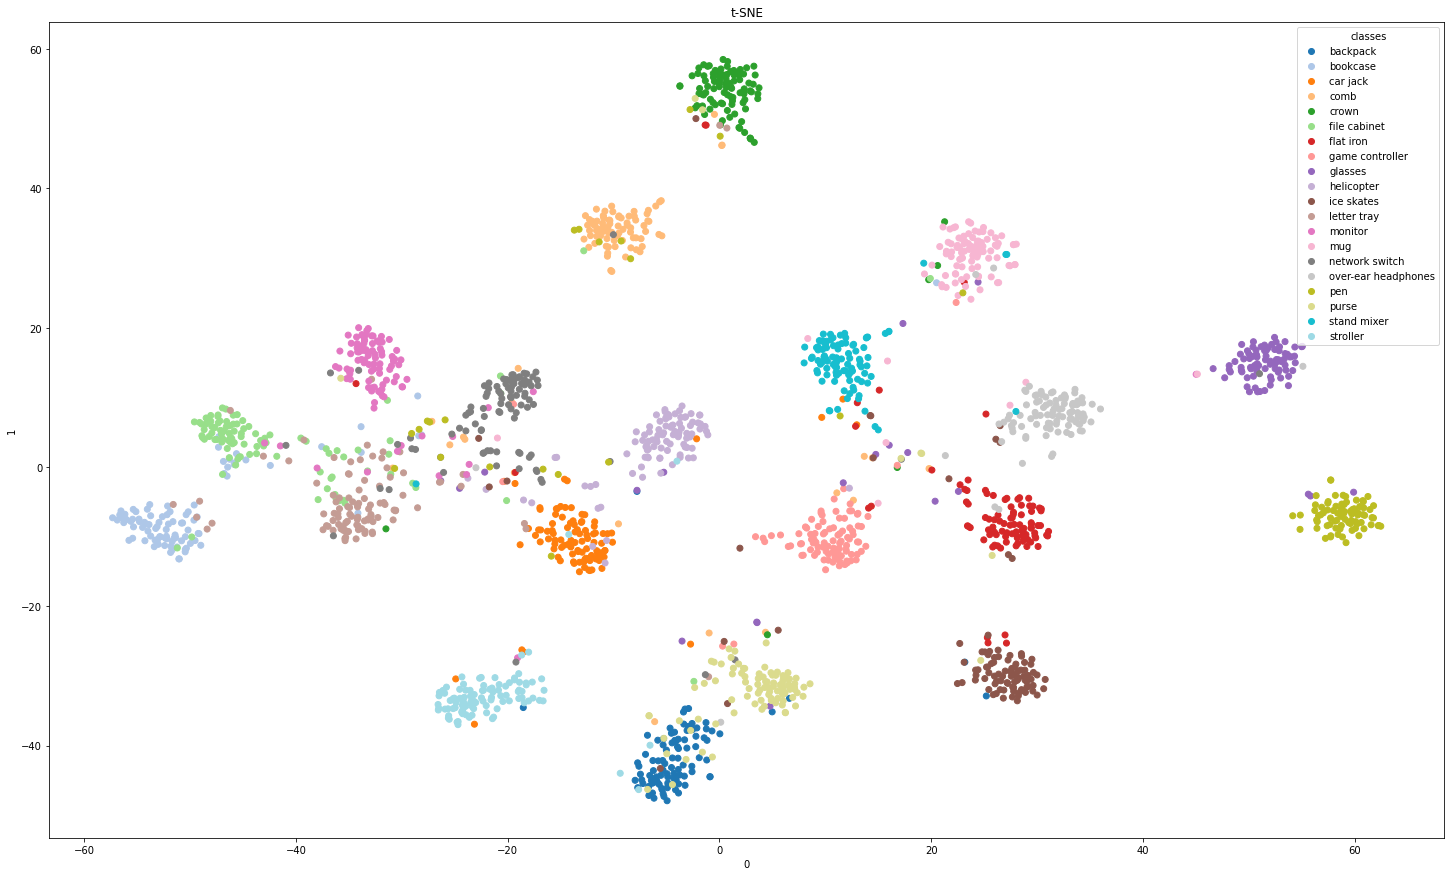

In [ ]:
# Computation of the t-SNE feature visualization with dots using the model with uda applied
outF_uda1, lS_uda1, lNuda1 = featureE(path.join(PATH, "Models/model_uda_realworld"), stat_rw_loader, imLRW)
t_sne_points(outF_uda1, lS_uda1, lNuda1, 'uda_rw')

Image: 100%|██████████| 2000/2000 [01:23<00:00, 23.89it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



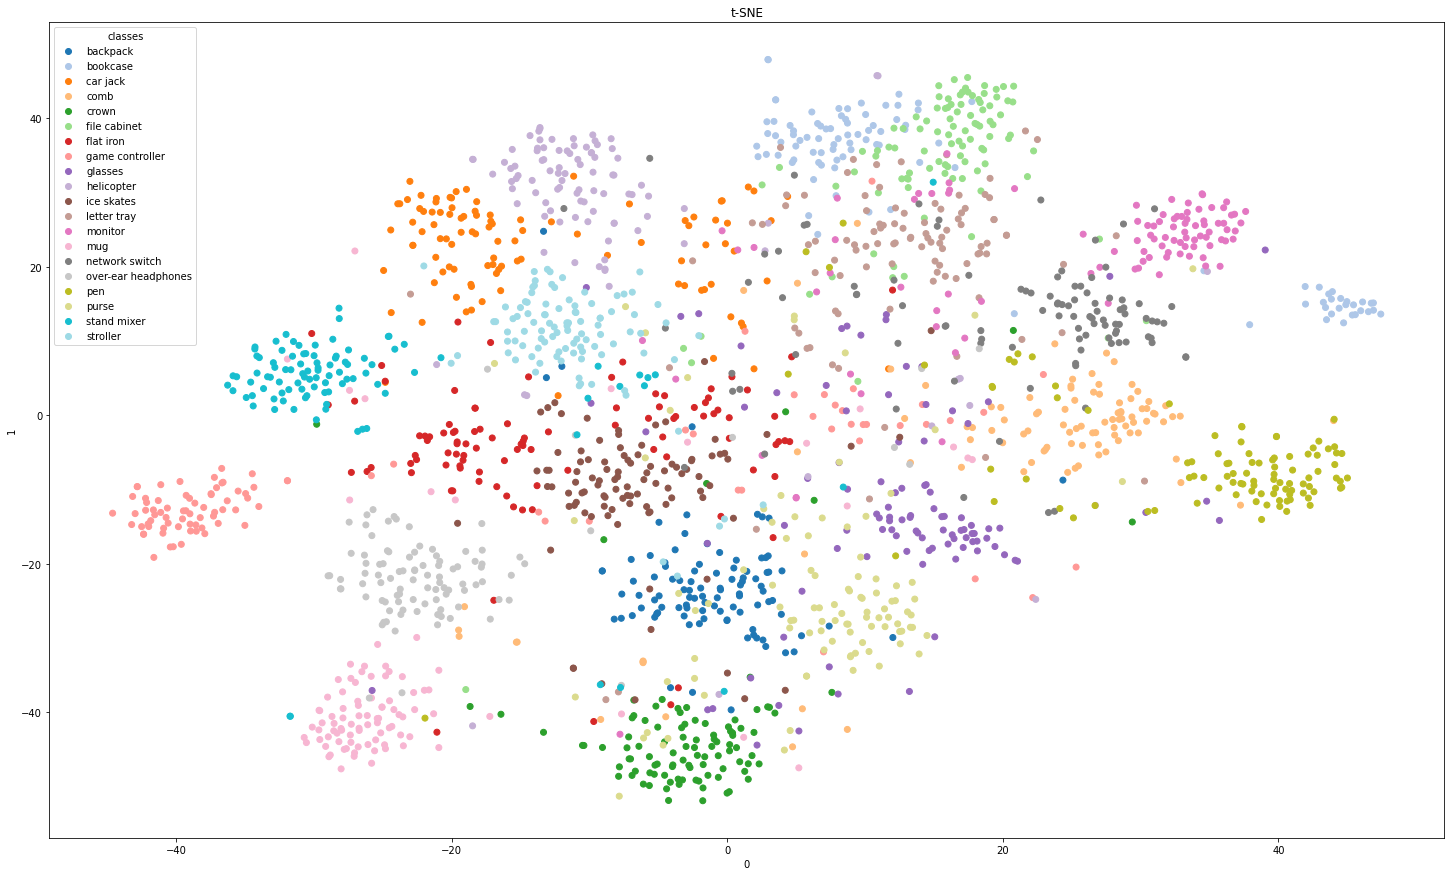

In [ ]:
# Computation of the t-SNE feature visualization with dots using the model without uda applied
outF1, lS1, lN1 = featureE(path.join(PATH, "Models/model_product"), stat_rw_loader, imLRW)
t_sne_points(outF1, lS1, lN1, 'product')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



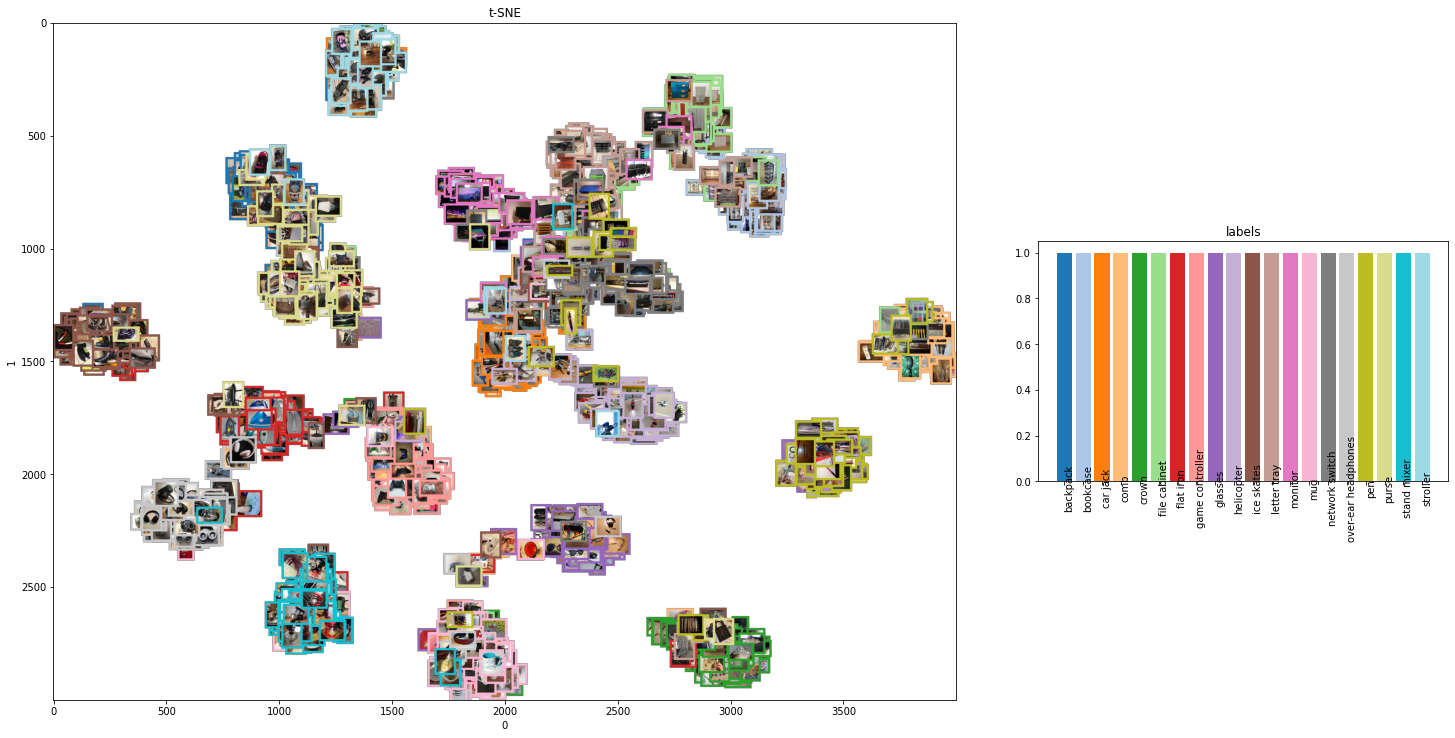

In [ ]:
# Computation of the t-SNE feature visualization with images using the model with uda applied
c_uda1 = t_sne_images(outF_uda1, imLRW, 'uda_rw')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



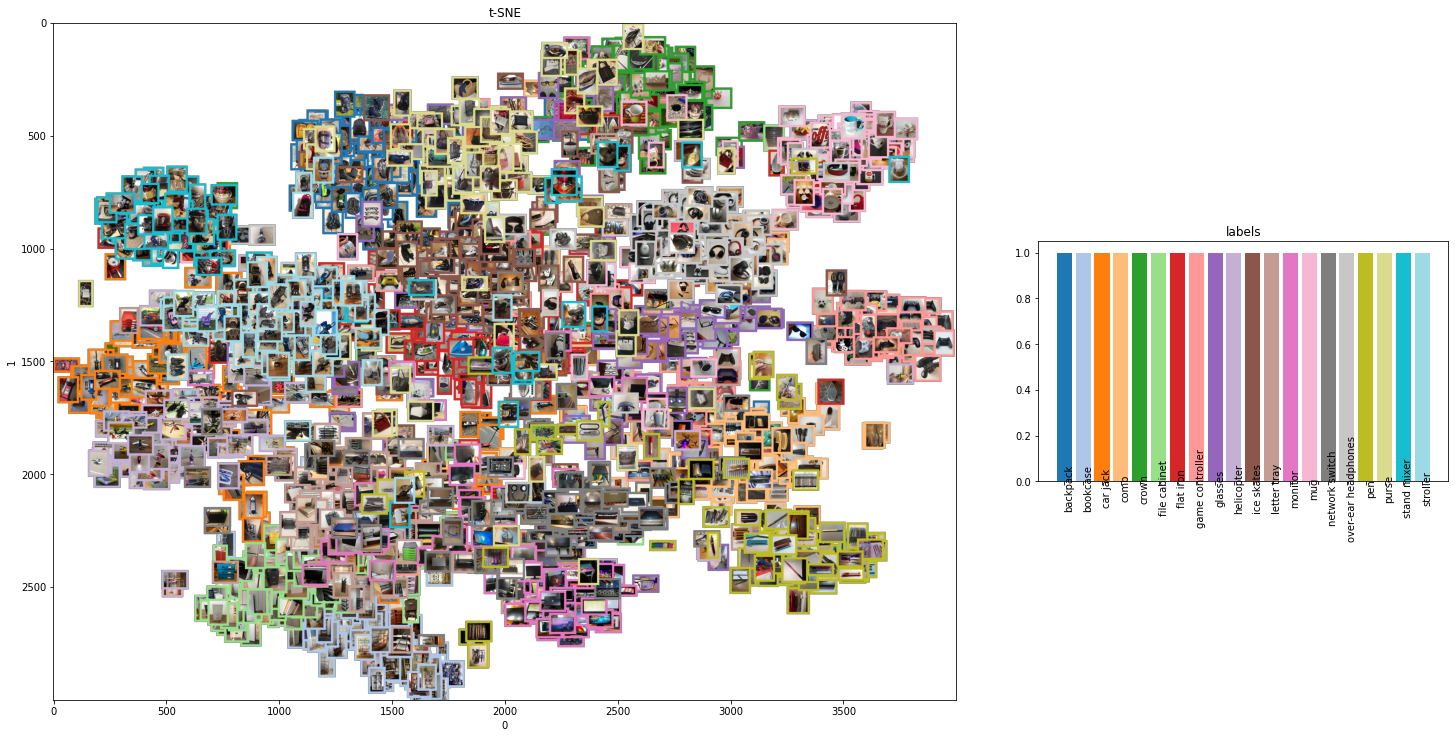

In [ ]:
# Computation of the t-SNE feature visualization with images using the model without uda applied
c1 = t_sne_images(outF1, imLRW, 'product')


<br/>

*      **DIRECTION: real world = source, product = target**

<br/>


Image: 100%|██████████| 2000/2000 [00:54<00:00, 36.94it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



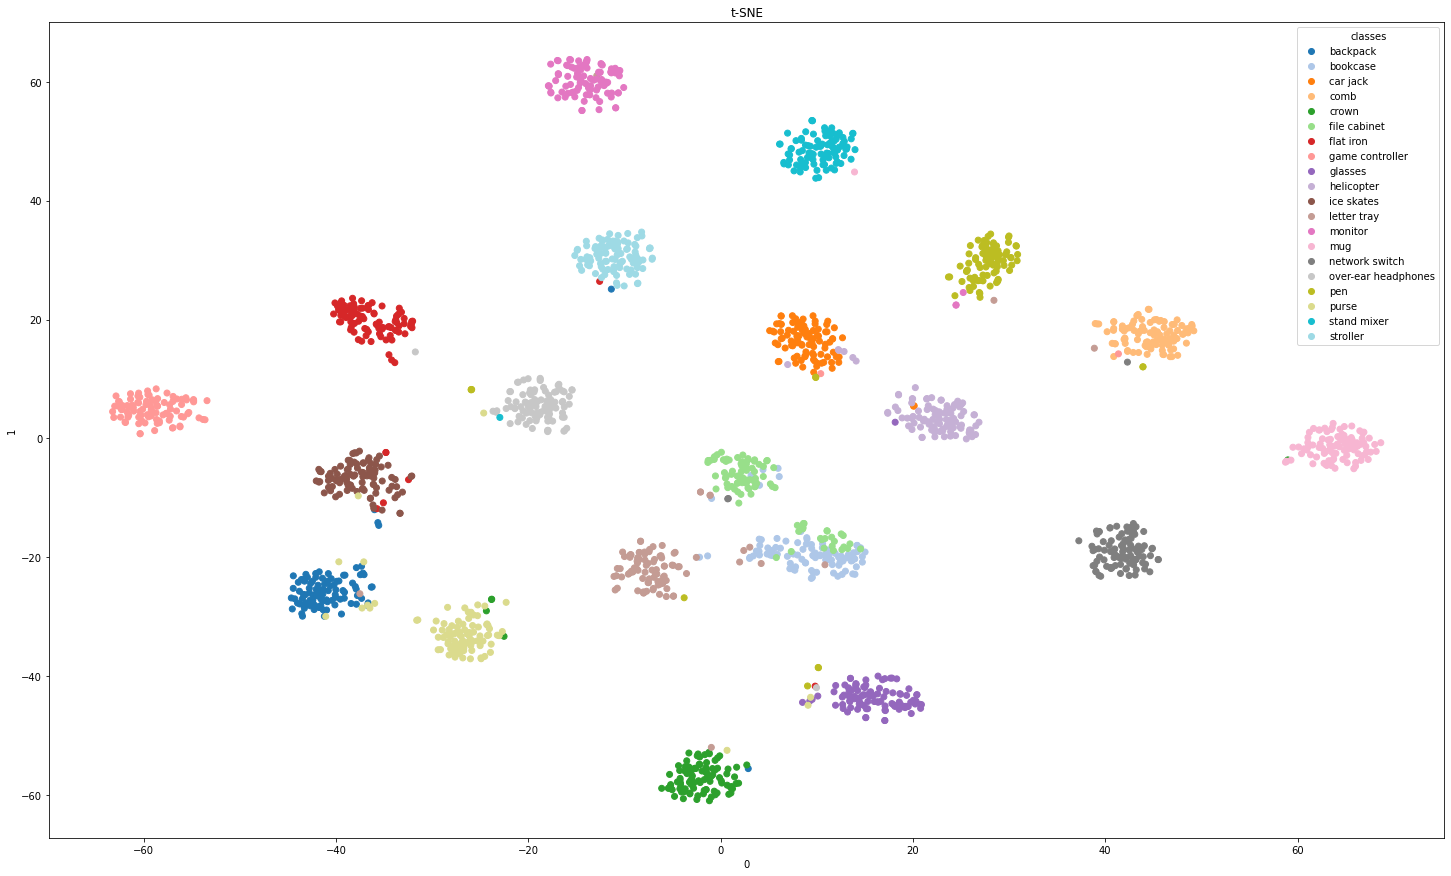

In [ ]:
# Computation of the t-SNE feature visualization with dots using the model with uda applied
outF_uda2, lS_uda2, lNuda2 = featureE(path.join(PATH, "Models/model_uda_product"), stat_product_loader, imLProduct)
t_sne_points(outF_uda2, lS_uda2, lNuda2, 'uda_product')

Image: 100%|██████████| 2000/2000 [00:55<00:00, 36.32it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



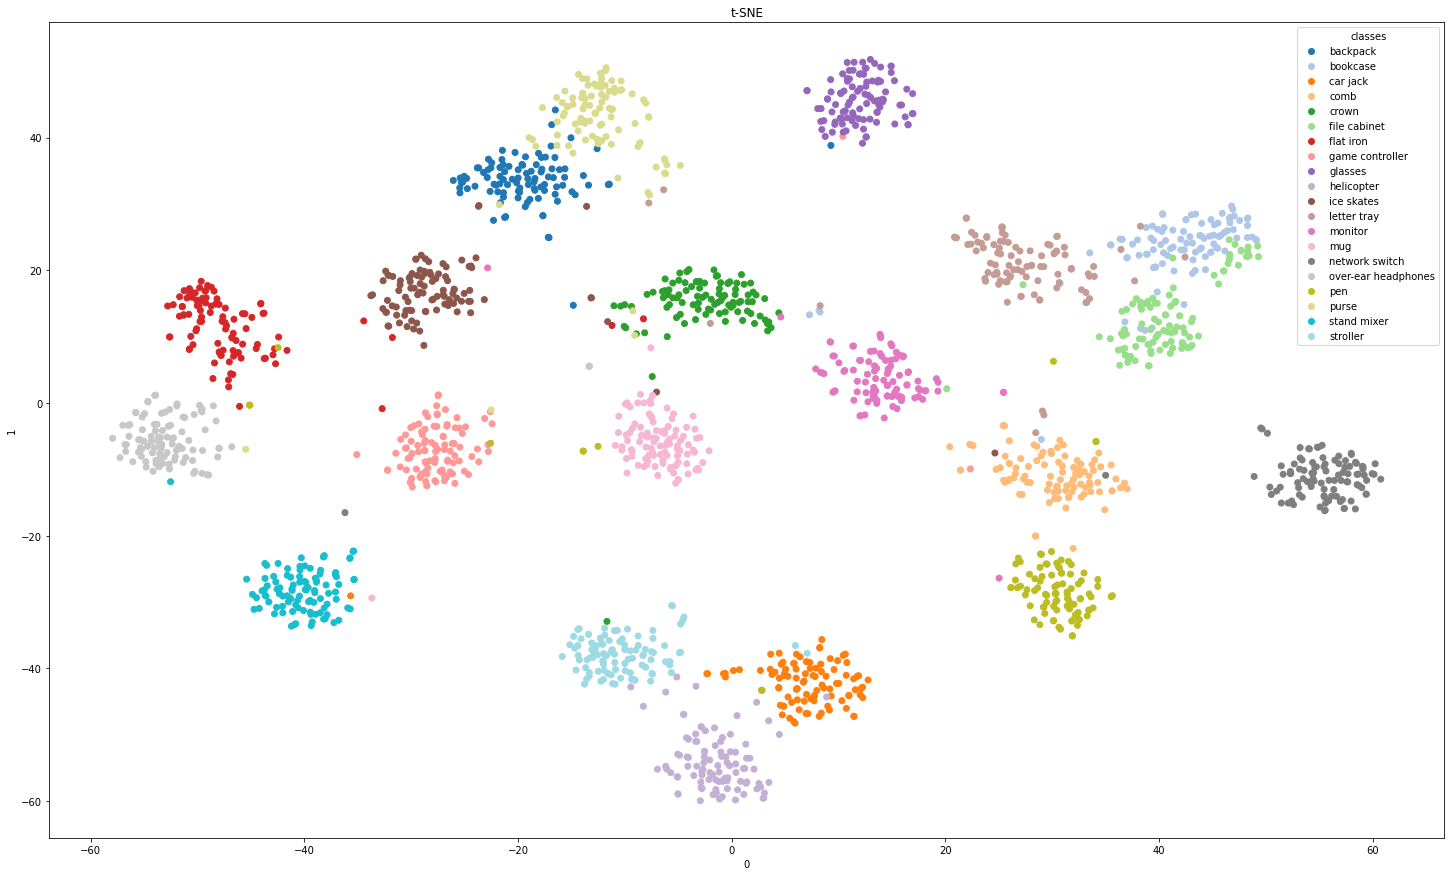

In [ ]:
# Computation of the t-SNE feature visualization with dots using the model without uda applied
outF2, lS2, lN2 = featureE(path.join(PATH, "Models/model_realworld"), stat_product_loader, imLProduct)
t_sne_points(outF2, lS2, lN2, 'realworld')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



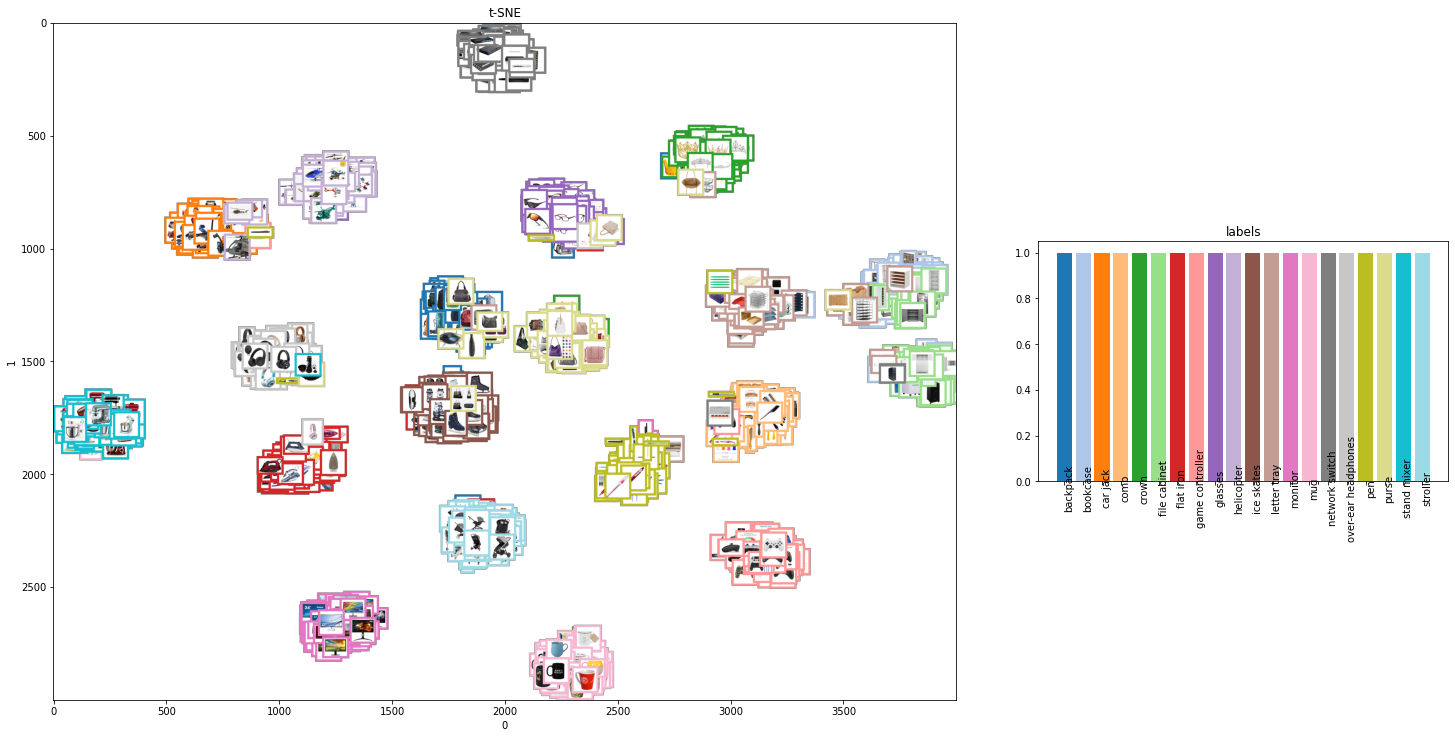

In [ ]:
# Computation of the t-SNE feature visualization with images using the model with uda applied
c_uda2 = t_sne_images(outF_uda2, imLProduct, 'uda_product')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



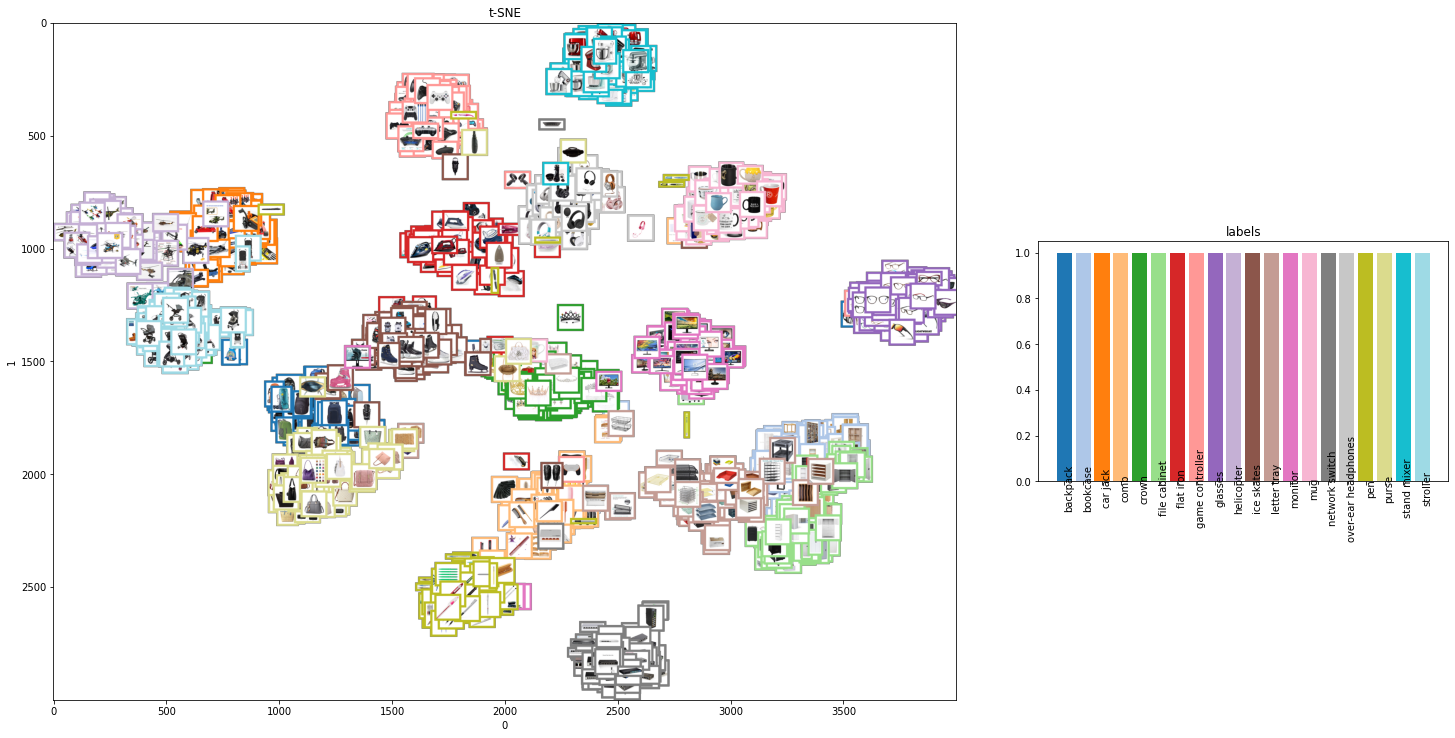

In [ ]:
# Computation of the t-SNE feature visualization with images using the model without uda applied
c2 = t_sne_images(outF2, imLProduct, 'realworld')

#### **Confusion matrix and misclassification errors per class**

<br/>

As the following images show, even the application of the UDA technique can't prevent completely the presence of some **misclassification errors**. Their quantity is higher in the direction *product $→$ real world* with respect to the opposite one.

As mentioned above, this is due to the fact that in the first direction the feature space on which the UDA framework starts its execution is not well organized yet. Therefore, reaching a good underlying clusterization of the features, in well separated and compact groups, is more challenging in this case than in the other direction (*real world $→$ product*), where the initial space results to be already well organized by the source-only model.


<br/>

*      **DIRECTION: product = source, real world = target**

</br>


In this direction the class with the highest number of misclassification errors is ***file cabinet***. As can be seen in the confusion matrix, the objects of this class are often mistaken by the network for ***letter trays***.

Examples of misclassified images can be extracted from the t-SNE feature visualization with images, that also allows to appreciate the proximity of the features of the two classes in the space:


<center>
<p float="center">
  <img src='https://drive.google.com/uc?export=view&id=1ARbuncO-0LfLnTDBdr95w8QUcDzUjzCV' width="200" />
    <img src='https://drive.google.com/uc?export=view&id=1U7xmY8QDDtnXCUGZ1LXX_ywNe-thxOpG' width="200" /> 
</p>
On the left: an image of the file cabinet class.
</br>
On the right: an image of the letter tray class.
</br>
As it can be seen the two images are very similar.
</center>

</br>

In addition, objects of the ***file cabinet*** class are sometimes mistaken with ***bookcases***. An example of similar images is:

<center>
<p float="center">
  <img src='https://drive.google.com/uc?export=view&id=1JcZFZCLfI9Mv2qItHBIg6PJr8pVRE0EY' width="200" /> 
  <img src='https://drive.google.com/uc?export=view&id=1Io-JBpLN4UdeQ743yJOgc72InNMI-LFz' width="200" />
</p>
On the left: an image of the bookcase class.
</br>
On the right: an image of the file cabinet class.
</center>


Image: 100%|██████████| 2000/2000 [01:25<00:00, 23.50it/s]


0  =  backpack
1  =  bookcase
2  =  car jack
3  =  comb
4  =  crown
5  =  file cabinet
6  =  flat iron
7  =  game controller
8  =  glasses
9  =  helicopter
10  =  ice skates
11  =  letter tray
12  =  monitor
13  =  mug
14  =  network switch
15  =  over-ear headphones
16  =  pen
17  =  purse
18  =  stand mixer
19  =  stroller


<Figure size 1800x1080 with 0 Axes>

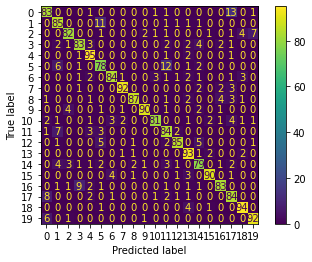

In [ ]:
# Computation of the confusion matrix
model = torch.load(path.join(PATH, "Models/model_uda_realworld"))
model.eval()
preds1 = []
trues1 = [] 
for sample, label in tqdm(stat_rw_loader, desc='Image'):
  input = sample.to(device)
  out = model(input)
  _, predicted = torch.max(out, 1)
  preds1.append(predicted.item())
  trues1.append(label.item())

labels = set(trues1)
for label in labels:
  print(label, ' = ', label_extractor(label, imLRW))

confusionMatrix(preds1, trues1, 'uda_rw')

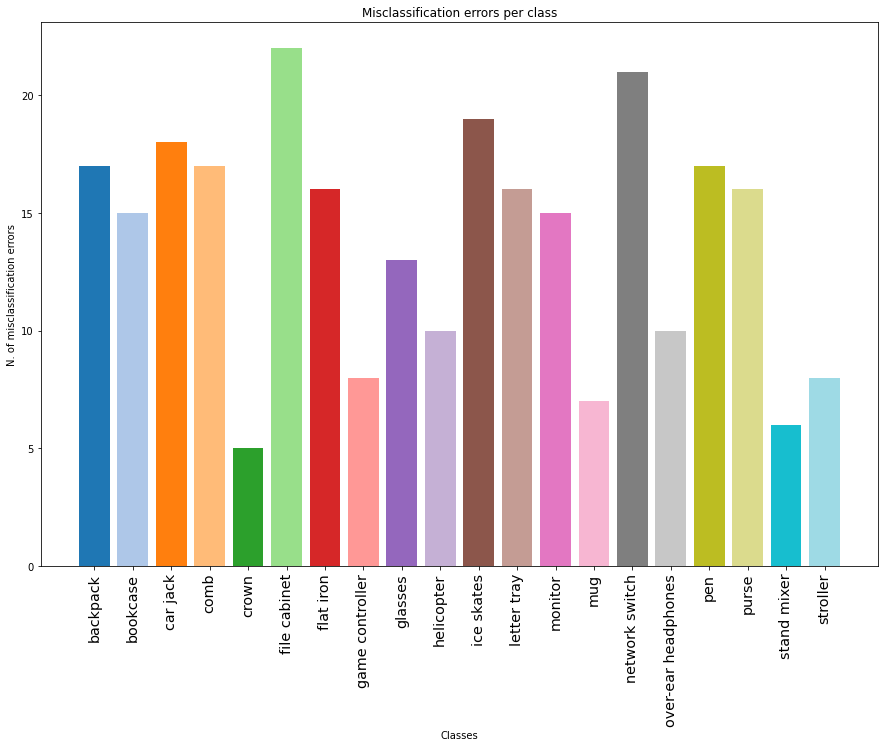

The file cabinet class is the class with more misclassification errors (22.0)


In [ ]:
# Computation of the misclassification errors per class histogram
hstEC(imLRW, preds1, NUM_CLASSES, path.join(p, "Adaptiope/real_life"), 'uda_rw')


<br/>

*      **DIRECTION: real world = source, product = target**

</br>

Also in this direction the class with the highest number of misclassification errors is ***file cabinet***. As can be seen in the confusion matrix, the objects of this class are often mistaken by the network for ***bookcases***.

Examples of misclassified images can be extracted from the t-SNE feature visualization with images, that also allows to appreciate the proximity of the features of the two classes in the space:

<center>
<p float="center">
  <img src='https://drive.google.com/uc?export=view&id=1Nrly2DNlcmcKneyXqSqKCQofCEahTEwr' width="200" /> 
  <img src='https://drive.google.com/uc?export=view&id=1Jy8ZjvlMr62GOvTu4uQonbydrtUNYqBB' width="200" />
</p>
On the left: an image of the file cabinet class.
</br>
On the right: an image of the bookcase class.
</br>
As it can be seen the two images are very similar.
</center>

Image: 100%|██████████| 2000/2000 [00:53<00:00, 37.08it/s]


0  =  backpack
1  =  bookcase
2  =  car jack
3  =  comb
4  =  crown
5  =  file cabinet
6  =  flat iron
7  =  game controller
8  =  glasses
9  =  helicopter
10  =  ice skates
11  =  letter tray
12  =  monitor
13  =  mug
14  =  network switch
15  =  over-ear headphones
16  =  pen
17  =  purse
18  =  stand mixer
19  =  stroller


<Figure size 1800x1080 with 0 Axes>

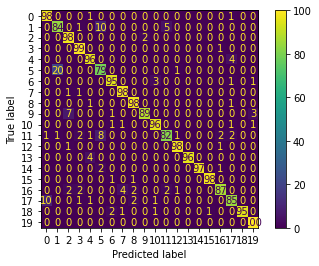

In [ ]:
# Computation of the confusion matrix
model = torch.load(path.join(PATH, "Models/model_uda_product"))
model.eval()
preds2 = []
trues2 = [] 
for sample, label in tqdm(stat_product_loader, desc='Image'):
  input = sample.to(device)
  out = model(input)
  _, predicted = torch.max(out, 1)
  preds2.append(predicted.item())
  trues2.append(label.item())

labels = set(trues1)
for label in labels:
  print(label, ' = ', label_extractor(label, imLProduct))

confusionMatrix(preds2, trues2, 'uda_product')

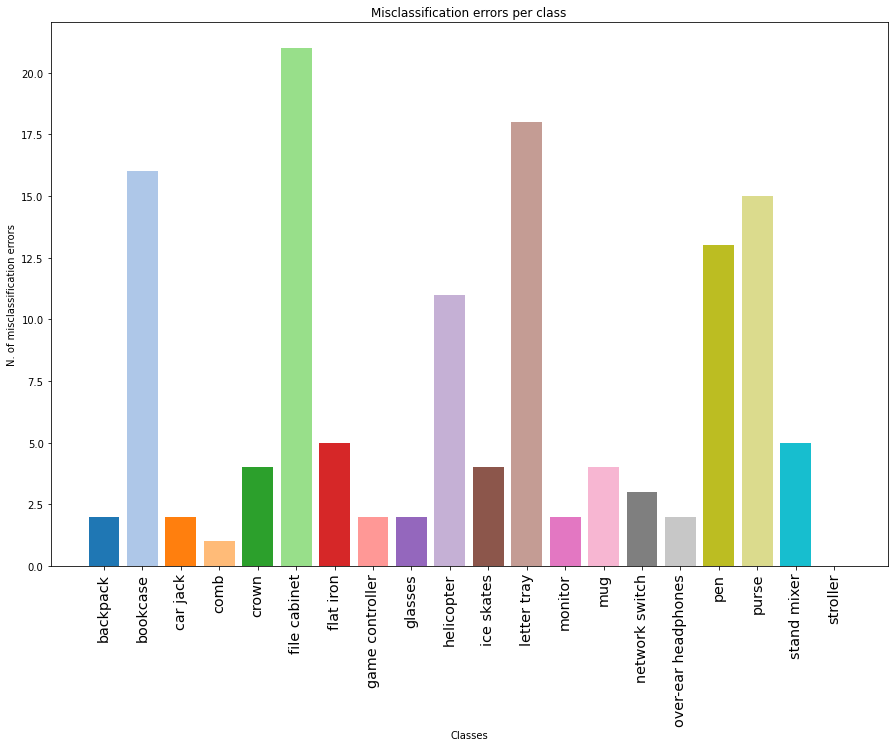

The file cabinet class is the class with more misclassification errors (21.0)


In [ ]:
# Computation of the misclassification errors per class histogram
hstEC(imLProduct, preds2, NUM_CLASSES, path.join(p, "Adaptiope/product_images"), 'uda_product')

#### **Accuracy and loss across epochs**

<br/>

The accuracy-per-epoch and loss-per-epoch graphs show that wide fluctuations on the accuracy and loss values are present in both directions. This may be due to the fact that, especially in the *real world $→$ product* case, the starting lower bound for the accuracy is already high. Therefore, the possible range of improvement is quite limited, making the optimization process difficult.

However, an **increasing tendency** can be observed for the accuracies over epochs and a **decreasing trend** for the losses over epochs.

This desirable behaviour supports the aforementioned good results in the gain we obtained applying the UDA method implemented in this file.


<br/>

*      **DIRECTION: product = source, real world = target**

<br/>


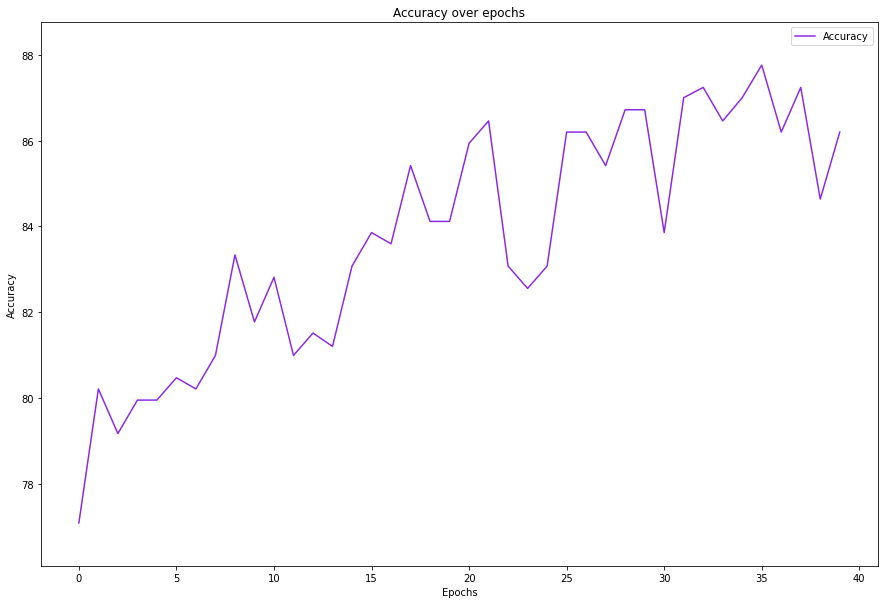

In [ ]:
# Computation of the accuracy per epoch graph
accuracies1 = []
h = open(path.join(PATH, "Results/", "acc_uda_realworld.txt"))
for line in h:
    s = len(line)
    accuracies1.append(line[:s - 2])

h.close()
acc1 = np.asarray(accuracies1)
accPlot(np.arange(0, len(acc1)), acc1.astype(float), 'uda_rw')

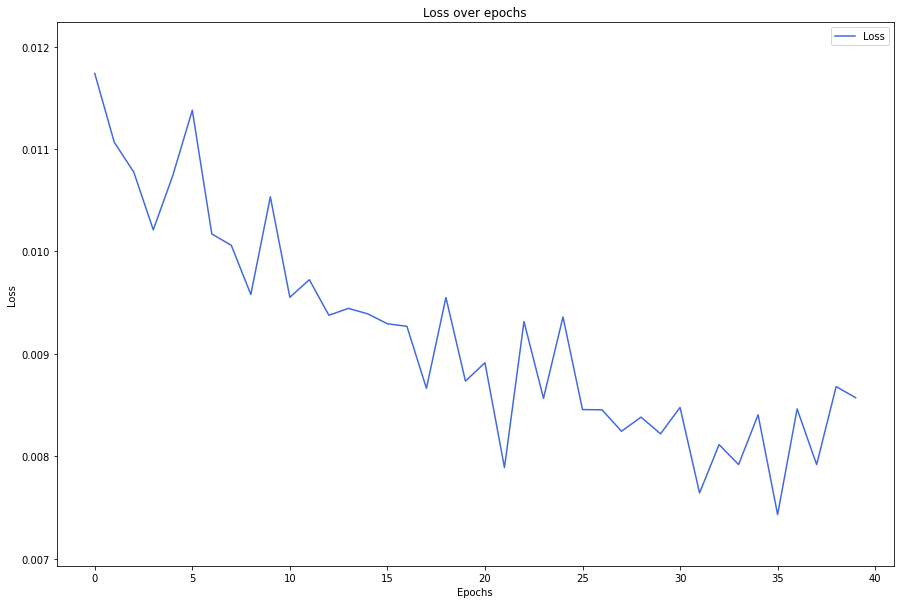

In [ ]:
# Computation of the loss per epoch graph
losses1 = []
h = open(path.join(PATH, "Results/", "l_uda_realworld.txt"))
for line in h:
    s = len(line)
    losses1.append(line[:s - 2])

h.close()
l1 = np.asarray(losses1)
lossPlot(np.arange(0, len(l1)), l1.astype(float), 'uda_rw')


<br/>

*      **DIRECTION: real world = source, product = target**

<br/>


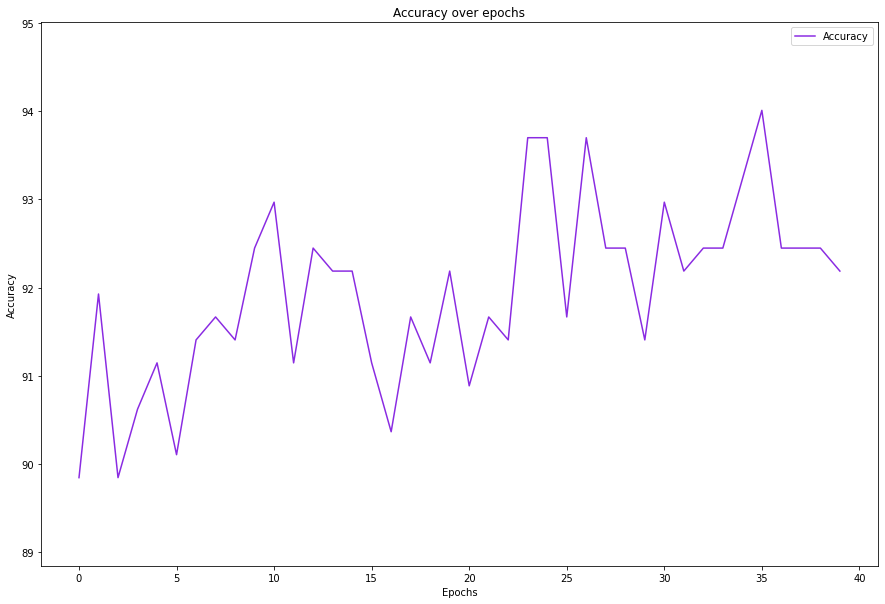

In [ ]:
# Computation of the accuracy per epoch graph
accuracies2 = []
h = open(path.join(PATH, "Results/", "acc_uda_product.txt"))
for line in h:
    s = len(line)
    accuracies2.append(line[:s - 2])

h.close()
acc2 = np.asarray(accuracies2)
accPlot(np.arange(0, len(acc2)), acc2.astype(float), 'uda_product')

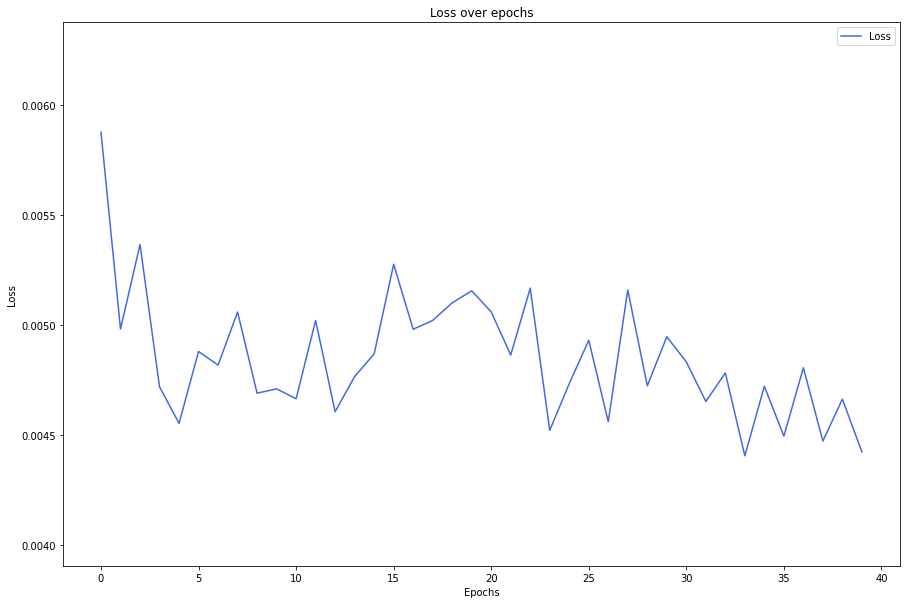

In [ ]:
# Computation of the loss per epoch graph
losses2 = []
h = open(path.join(PATH, "Results/", "l_uda_product.txt"))
for line in h:
    s = len(line)
    losses2.append(line[:s - 2])

h.close()
l2 = np.asarray(losses2)
lossPlot(np.arange(0, len(l2)), l2.astype(float), 'uda_product')